## Question 1 - Implementing a Seq2Seq model without Attention

### Importing Necessary Libraries

In [1]:
import csv
import numpy as np
import random
import torch
import torch.nn as nn 
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def print_keys_for_values(dictionary, values):
    found_keys = []
    for value in values:
        for key, val in dictionary.items():
            if value == val:
                found_keys.append(key)
    if found_keys:
        str = ''.join(found_keys)
        if(str[-1] == '\n'):
          str = str[:-1]
        elif(str[0] == '\t'):
          str = str[1:]
    else:
        print("No keys found for the given values.")

    return str


#Outputs = [32,68,22]
#Targets = [32,22]

def char_level_accuracy(targets, outputs):
    
  with torch.no_grad():
    count = 0
    total_count = 0
#     outputs = torch.argmax(outputs, dim = 1)
    for i in range(targets.shape[0]):
        same_elements = []
        for j in range(targets.shape[1]):
            if(targets[i][j] != 67 or targets[i][j] != 66):
                same_elements.append(outputs[i][j].item() == targets[i][j].item())
        count += np.sum(same_elements)
        total_count += len(same_elements)
  return count/(total_count)



def word_level_accuracy(targets, outputs):
  outputs1 = torch.argmax(outputs, dim = 1)
  with torch.no_grad():
    count = 0
    for i in range(targets.shape[0]):
      if ((outputs1[i] == targets[i]).sum().item() == targets.shape[1]):
        count = count + 1
  return count/targets.shape[0]

def sample_equidistant_points(data, epochs):
    step = len(data) // epochs
    indices = np.arange(0, len(data), step)
    equidistant_points = [data[i] for i in indices]
    
    return equidistant_points
  
# A = torch.tensor(np.array([[1,2,3,6],[1,2,3,7]]))
# B = torch.tensor(np.array([[1,2,6,6],[1,1,6,6]]))
# print(A)
# print(B)
# print(char_level_accuracy(A,B))


In [2]:
!pip install wandb -qU
import wandb
# print(wandb.util.generate_id())
# wandb sync --id= wandb.util.generate_id()

In [3]:
wandb.login()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adityanandakishore (berserank). Use `wandb login --relogin` to force relogin


### Data Preprocessing

#### Loading the data

In [4]:
file1 = open('/kaggle/input/eng-tam/tam_test.csv')
file2 = open('/kaggle/input/eng-tam/tam_valid.csv')
file3 = open('/kaggle/input/eng-tam/tam_train.csv')


csvreader1 = csv.reader(file1)
csvreader2 = csv.reader(file2)
csvreader3 = csv.reader(file3)


header1 = []
header1 = next(csvreader1)

header2 = []
header2 = next(csvreader2)

header3 = []
header3 = next(csvreader3)

test = []
val = []
train = []
for row in csvreader1:
        test.append(row)

for row in csvreader2:
        val.append(row)

for row in csvreader3:
        train.append(row)


file1.close()
file2.close()
file3.close()

#### Data Processing

In [5]:
def read_data(list):
  inputs = []
  targets = []
  for pair in list:
    inputs.append(pair[0])
    targets.append(pair[1])
  return inputs,targets

train_inputs, train_targets = read_data(train)
test_inputs, test_targets = read_data(test)
val_inputs, val_targets = read_data(val)

print(train_inputs[1])
print(train_targets[1])

avarantri
அவரன்றி


In [6]:
start_char = '\t'
end_char = '\n'
blank_char = ' '
unknown_char = '\r'

In [7]:

def language_dict(inputs,targets):
  input_dict = {}
  max_input_length = 0
  input_char = []

  target_dict = {}
  max_target_length = 0
  target_char = []
  #Encoding Inputs and updating input_dict
  for string in inputs:
    max_input_length = max(len(string), max_input_length)
    for char in string:
      if char not in input_dict:
        input_dict[char] = len(input_char)
        input_char.append(char)
  if blank_char not in input_dict:
    input_dict[blank_char] = len(input_char)
    input_char.append(blank_char)
    
  input_dict[unknown_char] = len(input_char)
  input_char.append(unknown_char)
  
  if start_char not in target_dict:
    target_dict[start_char] = len(target_char)
    target_char.append(start_char)

  for string in targets:
    max_target_length = max(len(string)+2, max_target_length)
    for char in string:
      if char not in target_dict:
        target_dict[char] = len(target_char)
        target_char.append(char)

  if end_char not in target_dict:
    target_dict[end_char] = len(target_char)
    target_char.append(end_char)

  if blank_char not in target_dict:
    target_dict[blank_char] = len(target_char)
    target_char.append(blank_char)
    
  return input_dict,max_input_length,input_char,target_dict ,max_target_length,target_char

# input_dict,max_input_length,input_char,target_dict ,max_target_length,target_char = language_dict(test_inputs,test_targets)     
input_dict,max_input_length,input_char,target_dict,max_target_length,target_char = language_dict(train_inputs+val_inputs+test_inputs,train_targets+val_targets+test_targets)     

def word_to_encoding(word_list, language_dict, max_length, language):
    encodings = []
    for word in word_list:
        encoding = []
        for char in word:
            if char in language_dict:
                encoding.append(language_dict[char])
            else:
                encoding.append(language_dict[unknown_char])
        if (language == 0):
          while len(encoding) < max_length:
              encoding.append(language_dict[blank_char])
        if (language == 1):
          encoding.insert(0,language_dict[start_char])
          while len(encoding) < max_length-1:
            encoding.append(language_dict[blank_char])
          encoding.append(language_dict[end_char])
        encodings.append(encoding)
    return encodings


  
def process_data(train,val,test,input_dict,target_dict,max_input_length,max_target_length):

  train_inputs, train_targets = read_data(train)
  test_inputs, test_targets = read_data(test)
  val_inputs, val_targets = read_data(val)

  encoded_train_inputs = word_to_encoding(train_inputs,input_dict,max_input_length,0)
  encoded_train_targets = word_to_encoding(train_targets,target_dict,max_target_length,1)
  encoded_val_inputs = word_to_encoding(val_inputs,input_dict,max_input_length,0)
  encoded_val_targets = word_to_encoding(val_targets,target_dict,max_target_length,1)
  encoded_test_inputs = word_to_encoding(test_inputs,input_dict,max_input_length,0)
  encoded_test_targets = word_to_encoding(test_targets,target_dict,max_target_length,1)

  return encoded_train_inputs,encoded_train_targets, encoded_val_inputs, encoded_val_targets, encoded_test_inputs, encoded_test_targets


encoded_train_inputs,encoded_train_targets,encoded_val_inputs, encoded_val_targets, encoded_test_inputs, encoded_test_targets = process_data(train,val,test,input_dict,target_dict,max_input_length,max_target_length)


r = random.randint(0,100)
print(print_keys_for_values(input_dict,encoded_train_inputs[int(r)]))
print(print_keys_for_values(target_dict,encoded_train_targets[int(r)]))


indhagoayilai                 
	இந்தகோயிலை             


In [8]:
def convert_to_tensor_pairs(train_inputs, train_targets):
    pairs = []
    for input_data, target_data in zip(train_inputs, train_targets):
        input_tensor = torch.tensor(input_data)
        target_tensor = torch.tensor(target_data)
        pairs.append((input_tensor,target_tensor))
    return pairs

encoded_train_pairs = convert_to_tensor_pairs(encoded_train_inputs,encoded_train_targets)

encoded_val_pairs = convert_to_tensor_pairs(encoded_val_inputs,encoded_val_targets)

encoded_test_pairs = convert_to_tensor_pairs(encoded_test_inputs,encoded_test_targets)

pairs = (encoded_train_pairs, encoded_val_pairs, encoded_test_pairs)
pair = random.choice(encoded_train_pairs)

print(print_keys_for_values(input_dict, pair[0]))
print(print_keys_for_values(target_dict, pair[1]))



enngalpoal                    
	எண்கள்போல்             


### Seq2Seq Model without Attention

#### Encoder

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, device, cell_type, vocab_size, embed_dim, hidden_size, num_layers=1, bidirectional=False, dropout_p=0):
        super(EncoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type
        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(self.dropout_p)
        if(cell_type == 'lstm'):
          self.rnn = nn.LSTM(embed_dim, hidden_size, num_layers = self.num_layers, batch_first=True, dropout = dropout_p, bidirectional=self.bidirectional)
        elif (cell_type == 'rnn'):
          self.rnn = nn.RNN(embed_dim, hidden_size, num_layers = self.num_layers, batch_first=True,dropout = dropout_p, bidirectional=self.bidirectional)
        elif (cell_type == 'gru'):
          self.rnn = nn.GRU(embed_dim, hidden_size, num_layers = self.num_layers, batch_first=True,dropout = dropout_p, bidirectional=self.bidirectional)

    def forward(self, x, hidden, cell):
        out = self.embedding(x)#.unsqueeze(1)
        out = self.dropout(out)
        if (self.cell_type == 'lstm'):
          out, (hidden, cell) = self.rnn(out, (hidden, cell))
          return out, hidden, cell
        elif (self.cell_type == 'rnn'):
          out, hidden = self.rnn(out, hidden)
          return out, hidden
        elif (self.cell_type == 'gru'):
          out, hidden = self.rnn(out,hidden) 
          return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.randn((1+int(self.bidirectional))*self.num_layers, batch_size, self.hidden_size, device=device)
        cell = torch.randn((1+int(self.bidirectional))*self.num_layers, batch_size, self.hidden_size, device=device)
        return hidden, cell


#### Decoder

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, device, cell_type, output_vocab, embed_size, hidden_size, max_length, dropout_p=0.1, num_layers = 1, bidirectional = False):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_vocab
        self.embed_size = embed_size
        self.dropout_p = dropout_p
        self.cell_type = cell_type 
        self.max_length = max_length
        self.device = device
        self.num_layers = num_layers
        self.embedding_decoder = nn.Embedding(self.output_size, self.embed_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.bidirectional = bidirectional


        if (cell_type == 'lstm'):
          self.rnn = nn.LSTM( self.embed_size, hidden_size, num_layers = self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout = self.dropout_p)
        elif (cell_type == 'gru'):
          self.rnn = nn.GRU( self.embed_size, hidden_size, num_layers = self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout = self.dropout_p)
        elif (cell_type == 'rnn'):
          self.rnn = nn.RNN( self.embed_size, hidden_size, num_layers = self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout = self.dropout_p)

        self.out = nn.Linear((1+int(self.bidirectional))*self.hidden_size, self.output_size)
        self.out_activation = nn.LogSoftmax(dim=-1)
  


    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded_decoder = self.embedding_decoder(input)
        embedded_decoder = self.dropout(embedded_decoder)


        if (self.cell_type == 'lstm'):
          output, (hidden, cell) = self.rnn(embedded_decoder, (hidden, cell))
        elif (self.cell_type == 'gru'):
          output, hidden = self.rnn(embedded_decoder, hidden)
        elif (self.cell_type == 'rnn'):
          output,hidden = self.rnn(embedded_decoder, hidden)
    
        output = F.relu(self.out(output))
        output = F.log_softmax(output,dim=-1)

        return output, hidden, cell

    def init_hidden(self, encoder_hidden, encoder_cell, encoder_bidirectional):
        hidden = encoder_hidden[-(1+int(encoder_bidirectional)): ].repeat(self.num_layers,1,1)
        cell = encoder_cell[-(1+int(encoder_bidirectional)): ].repeat(self.num_layers,1,1)
        return hidden, cell

#### Seq2Seq Model

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_target_length = 0
        self.sos = 0
        
        
    def forward(self, source, target, teacher_forcing_ratio = 0.5):
      
        batch_size = target.shape[0]
        target_len = target.shape[1]
        self.max_target_length = target_len
        target_vocab_size = self.decoder.output_size
        
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        encoder_hidden, encoder_cell = self.encoder.init_hidden(batch_size)

        
        if (self.encoder.cell_type == 'lstm'):
          encoder_outputs, encoder_hidden, encoder_cell = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'rnn'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'gru'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)


        #first input to the decoder is the <sos> tokens
        input = target[:,0]
        self.sos = target[:,0]
        hidden,cell = self.decoder.init_hidden(encoder_hidden, encoder_cell, self.encoder.bidirectional)
        
        for t in range(1, target_len):
            output, hidden, cell = self.decoder.forward(input, hidden, cell)
            outputs[:,t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(-1)
            input = target[:,t] if teacher_force else top1.squeeze(1)

        return outputs

    def inference(self, source, target):
      
        batch_size = source.shape[0]
        target_len = self.max_target_length
        target_vocab_size = self.decoder.output_size
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        encoder_hidden, encoder_cell = self.encoder.init_hidden(batch_size)

        
        if (self.encoder.cell_type == 'lstm'):
          encoder_outputs, encoder_hidden, encoder_cell = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'rnn'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'gru'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
           
        #first input to the decoder is the <sos> tokens
        input = self.sos

        hidden,cell = self.decoder.init_hidden(encoder_hidden, encoder_cell, self.encoder.bidirectional)
      
        
        for t in range(1, target_len):
            output, hidden, cell = self.decoder.forward(input, hidden, cell)
            outputs[:,t] = output.squeeze(1)
            top1 = output.argmax(-1)
            input = top1.squeeze(1)

        # print(f"Outputs = {outputs[:,0]}")
        # print(f"Targets = {target[:,0]}")
        
        return outputs

#### Training the Seq2Seq Model

In [12]:
input_dim = len(input_dict)
output_dim = len(target_dict)
batch_size = 32
val_batch_size = 32
enc_embedding = 256
dec_embedding = 256
hidden = 512
enc_num_layers = 3
dec_num_layers = 2
enc_dropout = 0.4
dec_dropout = 0.4
max_length = max_target_length
cell_type = 'gru'


    
enc = EncoderRNN(device, cell_type, input_dim, enc_embedding, hidden, enc_num_layers, bidirectional = True, dropout_p = enc_dropout)
dec = DecoderRNN(device, cell_type, output_dim, dec_embedding, hidden, max_length,  dec_dropout, dec_num_layers , bidirectional = True)
model = Seq2Seq(enc, dec, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.NLLLoss()


def trainIters(model, pairs, batch_size, n_iters, optimizer, tf, print_every=10, plot_every=10, log = True, Attention = False):
    start = time.time()
    plot_losses = []
    train_char_accuracy = []
    train_word_accuracy = []
    val_losses = []
    val_char_accuracy = []
    val_word_accuracy = []
    print_loss_total = 0  
    plot_loss_total = 0  
    print_val_loss_total = 0
    plot_val_loss_total = 0 

    train_pairs = pairs[0]
    val_pairs = pairs[1]
    train_accuracy = 0
    
    criterion = nn.NLLLoss()

    count = 0
    for iter in range(1,n_iters+1): 
      for i in np.arange(start=0, stop=len(train_pairs)-batch_size, step=batch_size):
        train_accuracy = 0
        count += 1
        if (i + batch_size > len(train_pairs)):
          batch_size = len(train_pairs) - i + 1  
        input_tensor = []
        target_tensor = []
        
        for j in range(batch_size):
            input_tensor.append(train_pairs[i+j][0])
            target_tensor.append(train_pairs[i+j][1]) 
            
        input_tensor = torch.stack(input_tensor).squeeze(1).long().cuda()
        target_tensor = torch.stack(target_tensor).squeeze(1).long().cuda()
        

        optimizer.zero_grad()
        if (count < 4000):
          out = model(input_tensor, target_tensor, teacher_forcing_ratio=tf)
        else:
          out = model(input_tensor, target_tensor , teacher_forcing_ratio=0)
        
        out = torch.permute(out,[0,2,1])
        # if (count%1000 == 0):
        #     print(f'Input Tensor:{print_keys_for_values(input_dict, input_tensor[1])}')
        #     print(f'Target Tensor:{print_keys_for_values(target_dict, target_tensor[1])}')
        #     print(f'Out Tensor:{print_keys_for_values(target_dict, torch.argmax(out[1], dim = 0))}')
        #     print(target_tensor[1])
        #     print(torch.argmax(out[1], dim = 0))
        loss = criterion(out, target_tensor)

#         train_accuracy_char = char_level_accuracy(target_tensor, out)*batch_size*target_tensor[1]
        
        
        train_accuracy_word = word_level_accuracy(target_tensor, out)*batch_size
        train_accuracy = train_accuracy + train_accuracy_word
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        print_loss_total += loss
        plot_loss_total += loss

        if count % 800 == 0:
            val_input_tensor = []
            val_target_tensor = []

            for j in range(batch_size):
                val_input_tensor.append(val_pairs[j][0])
                val_target_tensor.append(val_pairs[j][1]) 

            val_input_tensor = torch.stack(val_input_tensor).squeeze(1).long().cuda()
            val_target_tensor = torch.stack(val_target_tensor).squeeze(1).long().cuda()
            if (Attention == True):
                val_out,_ = model.inference(val_input_tensor, val_target_tensor)
                val_out = val_out.permute(0,2,1)
            else:
                val_out = model.inference(val_input_tensor, val_target_tensor)
                val_out = val_out.permute(0,2,1)
            val_loss = criterion(val_out, val_target_tensor)
            val_loss_sampled = val_loss
            wandb.log({'Val_Loss': val_loss_sampled})

            
        
        if count % 800 == 0:
            print_loss_avg = print_loss_total / 800
            print_loss_total = 0
            print('%s (%d %d%%) %.7f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
                                      

        if count % 800 == 0:
            plot_loss_avg = plot_loss_total / 800
            # train_char_accuracy.append(train_accuracy_char)
            # train_word_accuracy.append(train_accuracy_word)
            plot_losses.append(plot_loss_avg.detach())
            wandb.log({'Train Loss': plot_loss_avg})

            plot_loss_total = 0
        
      train_accuracy = train_accuracy/(len(train_pairs)-batch_size)
      train_word_accuracy.append(train_accuracy)#Need to log this list
    
    print(train_word_accuracy)
    plot_losses = [losses.cpu().numpy() for losses in plot_losses]
    plot_losses_sampled = sample_equidistant_points(plot_losses, n_iters)#Need to log this list
    
    char_count = 0
    word_count = 0
        
    for i in np.arange(start=0, stop=len(val_pairs)-batch_size, step=batch_size):
        if (i + batch_size > len(val_pairs)):
          batch_size = len(val_pairs) - i + 1  
        val_input_tensor = []
        val_target_tensor = []
        for j in range(batch_size):
            val_input_tensor.append(val_pairs[i+j][0])
            val_target_tensor.append(val_pairs[i+j][1])

        val_input_tensor = torch.stack(val_input_tensor).squeeze(1).long().cuda()
        val_target_tensor = torch.stack(val_target_tensor).squeeze(1).long().cuda()
        if (Attention == True):
            val_out,_ = model.inference(val_input_tensor, val_target_tensor)
            val_out = val_out.permute(0,2,1)
        else:
            val_out = model.inference(val_input_tensor, val_target_tensor)
            val_out = val_out.permute(0,2,1)
        val_loss = criterion(val_out, val_target_tensor)
        
        
        # print(torch.argmax(val_out, dim = 1))
        # print(val_target_tensor)


        # val_accuracy_char = char_level_accuracy(val_target_tensor, val_out)
        val_accuracy_word = word_level_accuracy(val_target_tensor, val_out)
        # char_count = char_count + (val_accuracy_char)*batch_size*val_target_tensor.shape[1]
        word_count = word_count + (val_accuracy_word)*batch_size
        # print(word_count)
    

    # char_accuracy = char_count/((len(val_pairs)-batch_size)*(val_target_tensor.shape[1]))
    word_accuracy = word_count/(len(val_pairs)-batch_size) #Need to log this value = Val_Word_Accuracy
    
    metrics = {'Val_Accuracy': word_accuracy}
    wandb.log(metrics)
    
                                
    
    print(f"Val loss = {val_loss}")
    # print(f'Character-level-accuracy on val set = {char_accuracy}')
    print(f'Word-level-accuracy on val set = {word_accuracy}')
    fig, axs = plt.subplots(2, figsize = (30,20))
    axs[0].plot(plot_losses_sampled)
    axs[0].set_ylabel('Train Loss')
    # axs[1].plot(train_char_accuracy)
    # axs[1].set_ylabel('Train Accuracy(Char)')
    axs[1].plot(train_word_accuracy)
    axs[1].set_ylabel('Train Accuracy(Word)')
    plt.show()

The model has 18,976,306 trainable parameters


## Question 2 - Seq2Seq Model WandB Sweep 

In [ ]:

sweep_config = {
    'method': 'bayes',
    'name' : 'Hyperparameter Tuning-Bayesian'
}

metric = {
    'name': 'Val_Accuracy',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric


parameters_dict = {
    'optimiser': {
        'values': ['adam']
        },
    'teacher_forcing_ratio':{
         'values':[0.5,0.7]
        },
    'bidirectional':{
         'values':[True]
        },
    'enc_embedding': {
        'values': [128]
        },
    'dec_embedding': {
        'values': [128]
        },
    'epochs': {
          'values': [5,8]
        },
    'hidden_size': {
          'values': [512]
        },
    'enc_layers': {
          'values': [3]
        },
    'dec_layers': {
          'values': [3]
        },
    'dropout': {
          'values': [0.3]
        },
    'cell_type': {
          'values': ['lstm']
        }
    }

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="CS6910 Assignment 3")


def train_sweep(config=None):
  with wandb.init(config=config) as run:
    config = wandb.config

    input_dim = len(input_dict)
    output_dim = len(target_dict)
    batch_size = 32
    val_batch_size = 32
    enc_embedding = config.enc_embedding
    dec_embedding = config.dec_embedding
    hidden = config.hidden_size
    enc_num_layers = config.enc_layers
    dec_num_layers = config.dec_layers
    enc_dropout = config.dropout
    dec_dropout = config.dropout
    max_length = max_target_length
    cell_type = config.cell_type


    
    enc = EncoderRNN(device, cell_type, input_dim, enc_embedding, hidden, enc_num_layers, bidirectional = config.bidirectional, dropout_p = enc_dropout)
    dec = DecoderRNN(device, cell_type, output_dim, dec_embedding, hidden, max_length,  dec_dropout, dec_num_layers , bidirectional = config.bidirectional)
    model = Seq2Seq(enc, dec, device).to(device)


    
    exp_name = str(config.cell_type) +'_e_'+ str(config.epochs)+'_hl_'+str(config.hidden_size)
    exp_name = exp_name + '_enc_'+ str(config.enc_embedding) + '_dec_'+ str(config.dec_embedding)+'_el_'+ str(config.enc_layers) + '_dl_'+ str(config.dec_layers)
    exp_name = exp_name+'_d_'+ str(config.dropout)+'_tf_'+ str(config.teacher_forcing_ratio)+'_optim_'+ config.optimiser
    
    wandb.run.name = exp_name
    if (config.optimiser == 'adam'):
      optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    elif (config.optimiser == 'nadam'):
      optimizer = torch.optim.NAdam(model.parameters(), lr = 0.001)

    criterion = nn.NLLLoss()
    trainIters(model, pairs, 32, config.epochs, optimizer, config.teacher_forcing_ratio)

wandb.agent(sweep_id, train_sweep, count= 50)
wandb.finish()

## Question 4- Model Inference on Test Data

In [14]:
#Printing the outputs in CSV files

#Create a CSV File

In [ ]:
def append_strings_to_csv(file_path, string1, string2, string3):
    with open(file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([string1, string2, string3])


input_dim = len(input_dict)
output_dim = len(target_dict)
batch_size = 32
val_batch_size = 32
enc_embedding = 128
dec_embedding = 256
hidden = 512
epochs = 5
enc_num_layers = 3
dec_num_layers = 1
enc_dropout = 0.4
dec_dropout = 0.4
max_length = max_target_length
cell_type = 'lstm'
teacher_forcing_ratio = 0.7

enc = EncoderRNN(device, cell_type, input_dim, enc_embedding, hidden, enc_num_layers, bidirectional = True, dropout_p = enc_dropout)
dec = DecoderRNN(device, cell_type, output_dim, dec_embedding, hidden, max_length,  dec_dropout, dec_num_layers , bidirectional = True)
model = Seq2Seq(enc, dec, device).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr = 0.001)
trainIters(model, pairs, 32, epochs, optimizer, teacher_forcing_ratio)
test_pairs = pairs[2]
test_word_count = 0

count = 1
name = 'Seq2SeqPredictions'+ str(count)
file_path = '/kaggle/working/'+name+'.csv'

for i in np.arange(start=0, stop=len(test_pairs)-batch_size, step=batch_size):
    if (i + batch_size > len(test_pairs)):
      batch_size = len(test_pairs) - i + 1  
    test_input_tensor = []
    test_target_tensor = []
    for j in range(batch_size):
        test_input_tensor.append(test_pairs[i+j][0])
        test_target_tensor.append(test_pairs[i+j][1])

    test_input_tensor = torch.stack(test_input_tensor).squeeze(1).long().cuda()
    test_target_tensor = torch.stack(test_target_tensor).squeeze(1).long().cuda()

    test_out = model.inference(test_input_tensor, test_target_tensor)
    test_out = test_out.permute(0,2,1)
    test_loss = criterion(test_out, test_target_tensor)
    for j in range(batch_size):
        input_str = print_keys_for_values(input_dict, test_input_tensor[j])
        output_str = print_keys_for_values(target_dict, torch.argmax(test_out[j], dim = 0))
        target_str = print_keys_for_values(target_dict, test_target_tensor[j])
        append_strings_to_csv(file_path, input_str, target_str, output_str)
    
    # print(torch.argmax(val_out, dim = 1))
    # print(val_target_tensor)


    # val_accuracy_char = char_level_accuracy(val_target_tensor, val_out)
    test_accuracy_word = word_level_accuracy(test_target_tensor, test_out)
    # char_count = char_count + (val_accuracy_char)*batch_size*val_target_tensor.shape[1]
    test_word_count = test_word_count + (test_accuracy_word)*batch_size
    # print(word_count)


    # char_accuracy = char_count/((len(val_pairs)-batch_size)*(val_target_tensor.shape[1]))
test_word_accuracy = test_word_count/(len(test_pairs)-batch_size)
print(f"Accuracy on Test Set is {test_word_accuracy}")

## Question 5 - Seq2Seq with Attention

#### Attention Decoder

In [13]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, device, cell_type, output_vocab, embed_size, hidden_size, max_length, dropout_p=0.1, num_layers = 1, bidirectional = False):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_vocab
        self.embed_size = embed_size
        self.dropout_p = dropout_p
        self.cell_type = cell_type 
        self.max_length = max_length
        self.device = device
        self.num_layers = num_layers
        self.embedding_decoder = nn.Embedding(self.output_size, self.embed_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.bidirectional = bidirectional


        if (cell_type == 'lstm'):
          self.rnn = nn.LSTM( self.embed_size + hidden_size*(1+int(self.bidirectional)), hidden_size, num_layers = self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout = self.dropout_p)
        elif (cell_type == 'gru'):
          self.rnn = nn.GRU(self.embed_size+ hidden_size*(1+int(self.bidirectional)), hidden_size, num_layers = self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout = self.dropout_p)
        elif (cell_type == 'rnn'):
          self.rnn = nn.RNN(self.embed_size+ hidden_size*(1+int(self.bidirectional)), hidden_size, num_layers = self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout = self.dropout_p)


        self.energy = nn.Linear(hidden_size*(2+int(self.bidirectional)),hidden_size)
        self.value = nn.Linear(hidden_size,1, bias = False)
        self.softmax = nn.Softmax(dim = 0)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.out = nn.Linear((1+int(self.bidirectional))*self.hidden_size, self.output_size)
        self.out_activation = nn.LogSoftmax(dim=-1)
  
        self.hidden_reshape_linear = nn.Linear(hidden_size*2,hidden_size)


    def forward(self, input, encoder_states, hidden, cell):
        input = input.unsqueeze(1)
        embedded_decoder = self.embedding_decoder(input)
        embedded_decoder = self.dropout(embedded_decoder)

        encoder_states = encoder_states.permute(1,0,2)
        sequence_length = encoder_states.shape[0]
        if self.bidirectional == True:
          hidden_1 = self.relu(self.hidden_reshape_linear(hidden[0:2].permute(1,0,2).reshape(hidden.shape[1],-1))).unsqueeze(0)
        else:
          hidden_1 = hidden[0]

          
        hidden_reshaped = hidden_1.repeat(sequence_length,1,1)

        energy = self.value(self.tanh(self.energy(torch.cat((hidden_reshaped,encoder_states),dim=2))))
        attention = self.softmax(energy)
        attention = attention.permute(1,2,0)
        encoder_states = encoder_states.permute(1,0,2)
        context_vector = torch.bmm(attention, encoder_states)

        rnn_input = torch.cat((context_vector,embedded_decoder), dim = 2)
      
        
        if (self.cell_type == 'lstm'):
          decoder_output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        elif (self.cell_type == 'gru'):
          decoder_output, hidden = self.rnn(rnn_input, hidden)
        elif (self.cell_type == 'rnn'):
          decoder_output,hidden = self.rnn(rnn_input, hidden)

        output = F.relu(self.out(decoder_output))
        output = F.log_softmax(output,dim=-1)

        return output, hidden, cell, attention

    def init_hidden(self, encoder_hidden, encoder_cell, encoder_bidirectional):
        hidden = encoder_hidden[-(1+int(encoder_bidirectional)): ].repeat(self.num_layers,1,1)
        cell = encoder_cell[-(1+int(encoder_bidirectional)): ].repeat(self.num_layers,1,1)
        return hidden, cell

In [14]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_target_length = 0
        self.sos = 0
               
    def forward(self, source, target, teacher_forcing_ratio = 0.5):
      
        batch_size = target.shape[0]
        target_len = target.shape[1]
        self.max_target_length = target_len
        target_vocab_size = self.decoder.output_size
        
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        encoder_hidden, encoder_cell = self.encoder.init_hidden(batch_size)

        
        if (self.encoder.cell_type == 'lstm'):
          encoder_outputs, encoder_hidden, encoder_cell = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'rnn'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'gru'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
           
        #first input to the decoder is the <sos> tokens
        input = target[:,0]
        self.sos = target[:,0]
        hidden,cell = self.decoder.init_hidden(encoder_hidden, encoder_cell, self.encoder.bidirectional)
        
        for t in range(1, target_len):
            output, hidden, cell,_ = self.decoder.forward(input, encoder_outputs, hidden, cell)
            outputs[:,t] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(-1)
            input = target[:,t] if teacher_force else top1.squeeze(1)

        return outputs

    def inference(self, source, target):
      
        batch_size = source.shape[0]
        target_len = self.max_target_length
        target_vocab_size = self.decoder.output_size
        
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        encoder_hidden, encoder_cell = self.encoder.init_hidden(batch_size)

        
        if (self.encoder.cell_type == 'lstm'):
          encoder_outputs, encoder_hidden, encoder_cell = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'rnn'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
        if (self.encoder.cell_type == 'gru'):
          encoder_outputs, encoder_hidden = self.encoder.forward(source, encoder_hidden, encoder_cell)
           
        #first input to the decoder is the <sos> tokens
        input = self.sos
        input_len = encoder_outputs.shape[1]
        hidden,cell = self.decoder.init_hidden(encoder_hidden, encoder_cell, self.encoder.bidirectional)
        attention_map = torch.zeros(batch_size,target_len,input_len)
        
        for t in range(1, target_len):
            output, hidden, cell, attention = self.decoder.forward(input,encoder_outputs, hidden, cell)
            attention_map[:,t-1,:] = attention.squeeze(1)
            outputs[:,t] = output.squeeze(1)
            top1 = output.argmax(-1)
            input = top1.squeeze(1)
        
#         attention_map = torch.cat(attention_map_list, dim=1)
        # print(f"Outputs = {outputs[:,0]}")
        # print(f"Targets = {target[:,0]}")
        
        return outputs, attention_map

In [ ]:
input_dim = len(input_dict)
output_dim = len(target_dict)
batch_size = 32
val_batch_size = 32
enc_embedding = 128
dec_embedding = 256
hidden = 512
enc_num_layers = 2
dec_num_layers = 2
enc_dropout = 0.4
dec_dropout = 0.4
max_length = max_target_length
cell_type = 'lstm'
teacher_forcing_ratio = 0.7

    
enc = EncoderRNN(device, cell_type, input_dim, enc_embedding, hidden, enc_num_layers, bidirectional = True, dropout_p = enc_dropout)
dec = AttentionDecoderRNN(device, cell_type, output_dim, dec_embedding, hidden, max_length,  dec_dropout, dec_num_layers , bidirectional = True)
model = AttentionSeq2Seq(enc, dec, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.NAdam(model.parameters(), lr = 0.001)
criterion = nn.NLLLoss()
wandb.init(project="CS6910 Assignment 3-Attention")
trainIters(model, pairs, 32, 6, optimizer, teacher_forcing_ratio, Attention = True)

The model has 23,957,042 trainable parameters


Train Loss,█▃▂▁▁▁▁▁▁▁▁
Val_Accuracy,▁
Val_Loss,█▇▂▂▄▁▂▂▁▁▁
Train Loss,2.01985
Val_Accuracy,0.0
Val_Loss,1.52819


#### WandB Sweep (without Attention)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: mwrvgv0e
Sweep URL: https://wandb.ai/berserank/CS6910%20Assignment%203/sweeps/mwrvgv0e


wandb: Agent Starting Run: rke28jmc with config:
wandb: 	bidirectional: False
wandb: 	cell_type: lstm
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 2
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 128
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.5


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


1m 14s (- 4m 59s) (1 20%) 1.5121756
2m 18s (- 3m 28s) (2 40%) 0.8682453
3m 22s (- 5m 3s) (2 40%) 0.4133559
4m 26s (- 2m 57s) (3 60%) 0.3381314
5m 29s (- 3m 39s) (3 60%) 0.2692216
6m 33s (- 1m 38s) (4 80%) 0.3269134
7m 37s (- 1m 54s) (4 80%) 0.3119850
8m 40s (- 0m 0s) (5 100%) 0.3059405
9m 44s (- 0m 0s) (5 100%) 0.2911028
[9.771923309945863e-05, 0.00011726307971935036, 0.00017589461957902554, 0.00017589461957902554, 0.00017589461957902554]
Val loss = 0.4643595516681671
Word-level-accuracy on val set = 0.20379030273197146


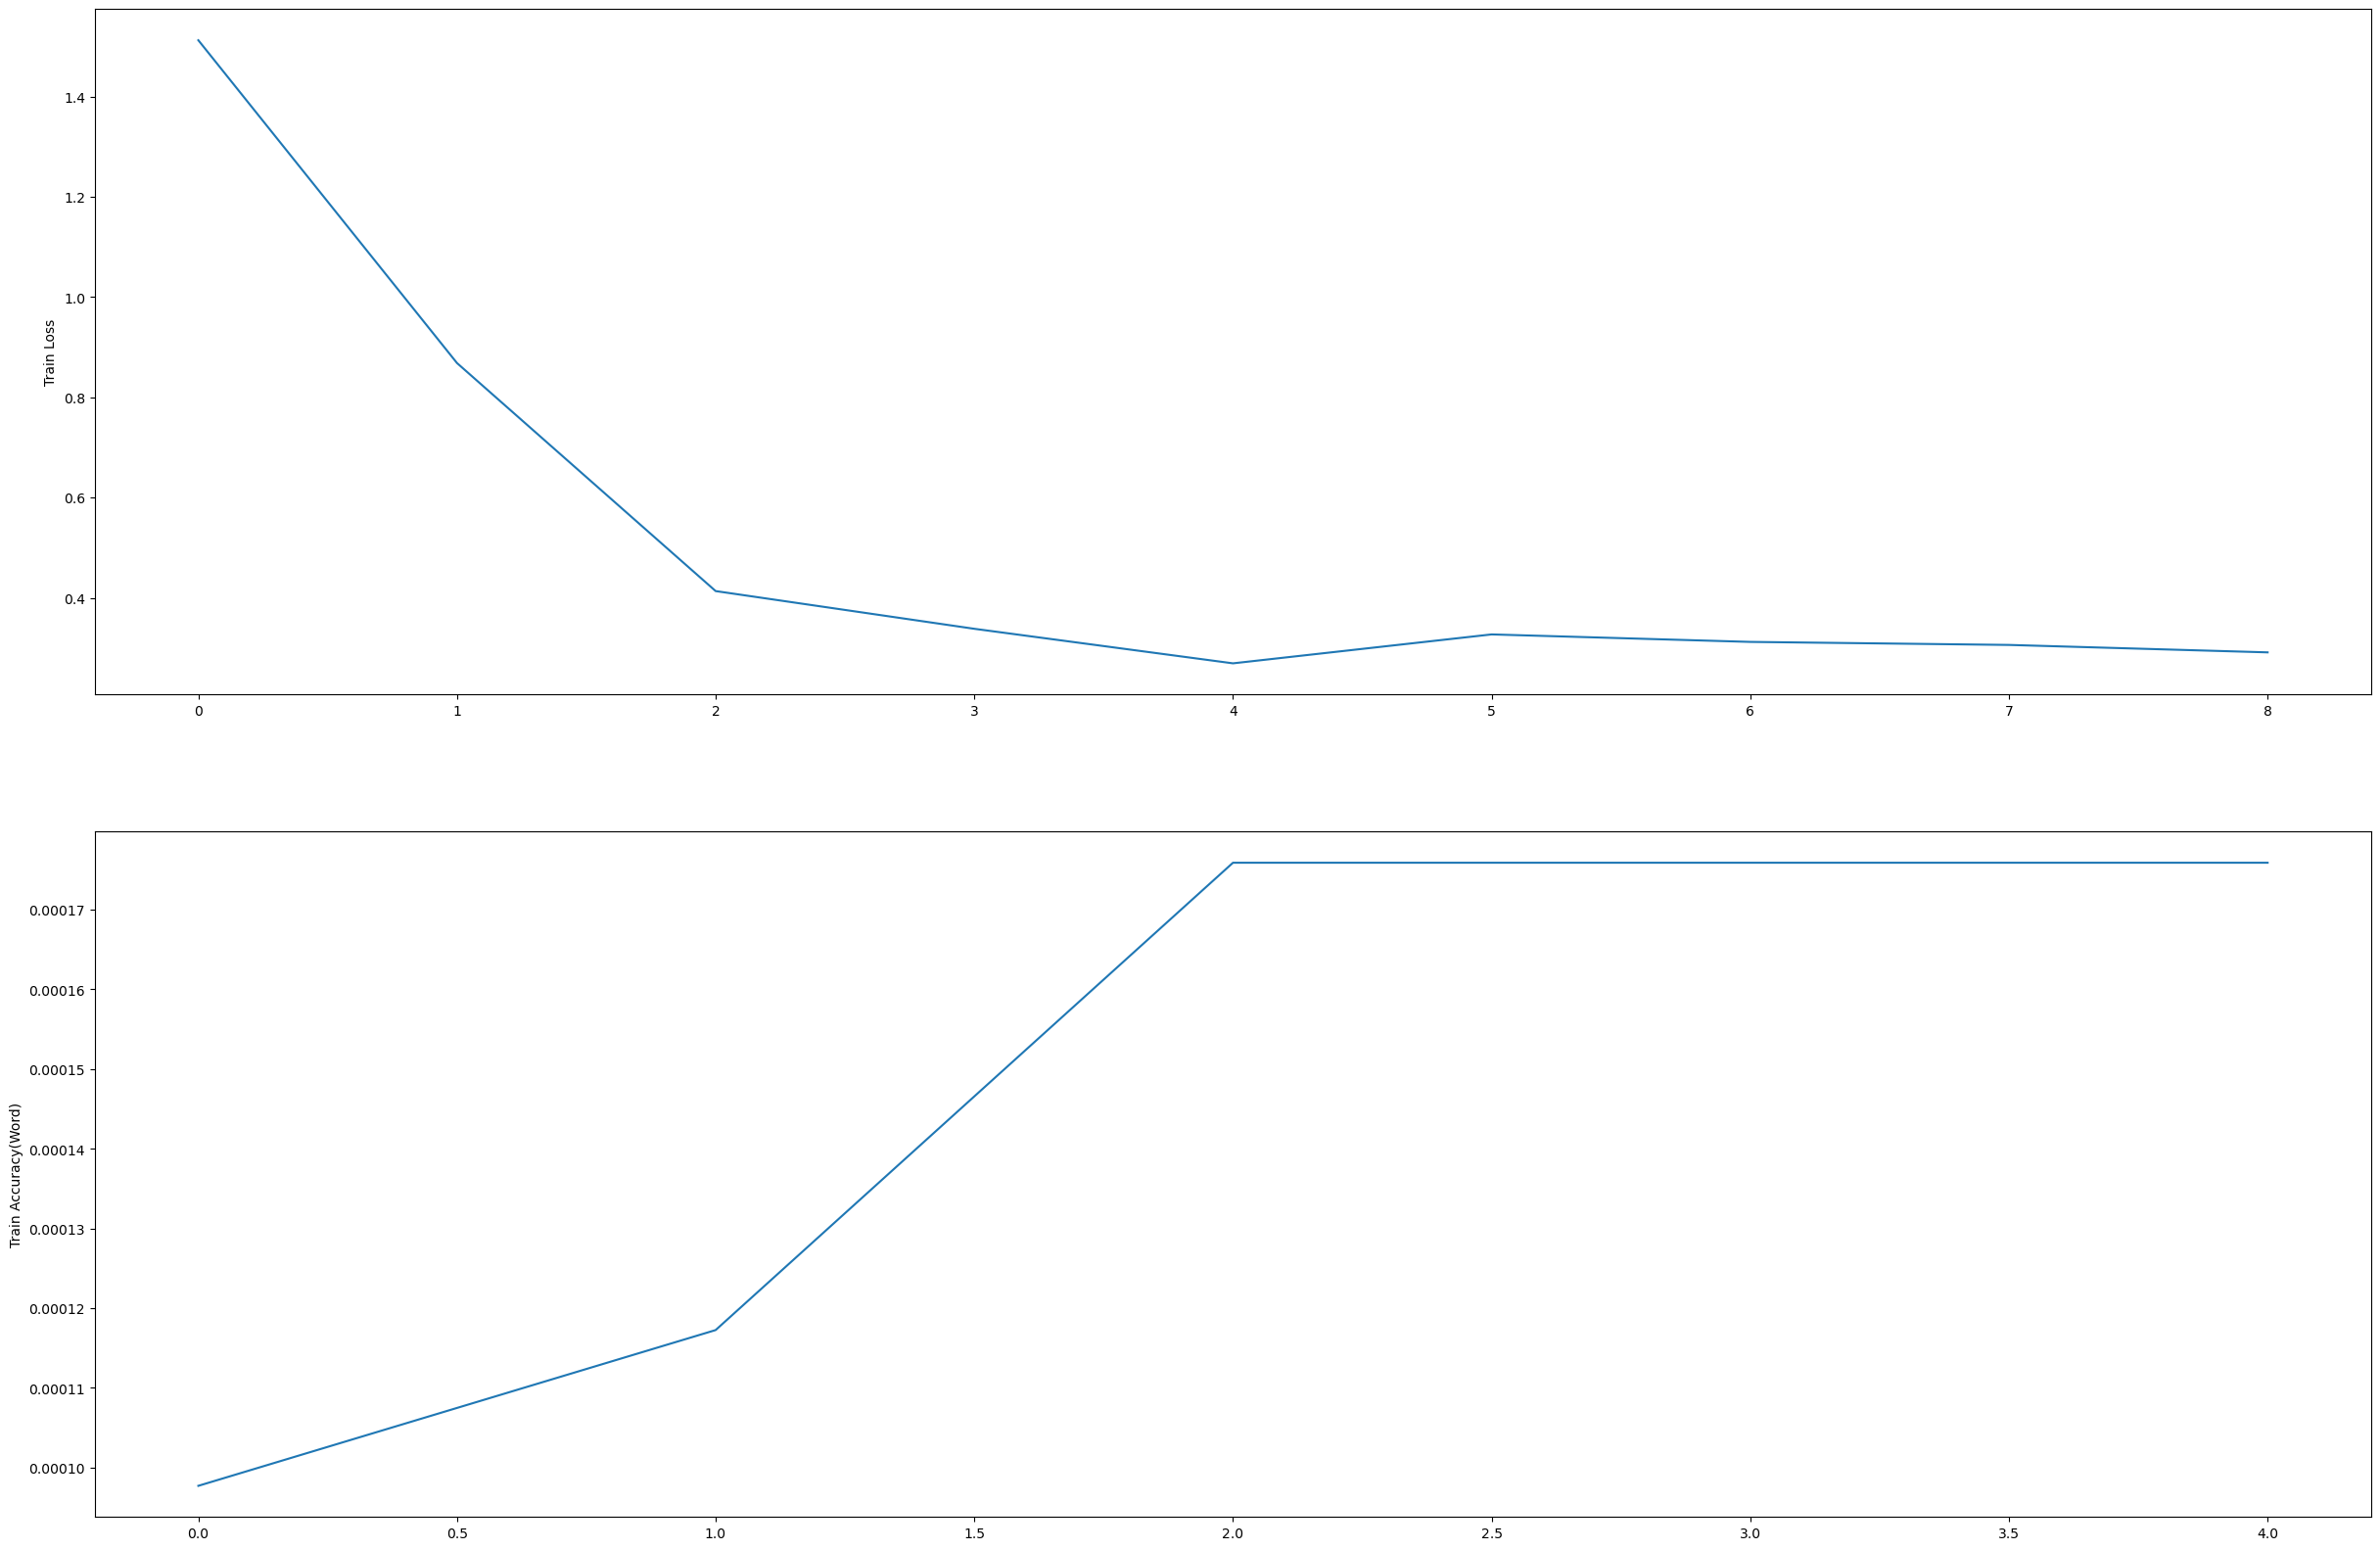

Train Loss,█▄▂▁▁▁▁▁▁
Val_Accuracy,▁
Val_Loss,█▃▂▁▁▁▁▁▁
Train Loss,0.2911
Val_Accuracy,0.20379
Val_Loss,0.35649


wandb: Agent Starting Run: mek11dul with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 128
wandb: 	enc_layers: 2
wandb: 	epochs: 3
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


1m 57s (- 3m 54s) (1 33%) 0.7491961
3m 50s (- 1m 55s) (2 66%) 0.1922443
5m 44s (- 2m 52s) (2 66%) 0.1439477
7m 37s (- 0m 0s) (3 100%) 0.1275629
9m 31s (- 0m 0s) (3 100%) 0.1196929
[0.0003517892391580511, 0.0003908769323978345, 0.0003517892391580511]
Val loss = 0.3263309895992279
Word-level-accuracy on val set = 0.3357125276888998


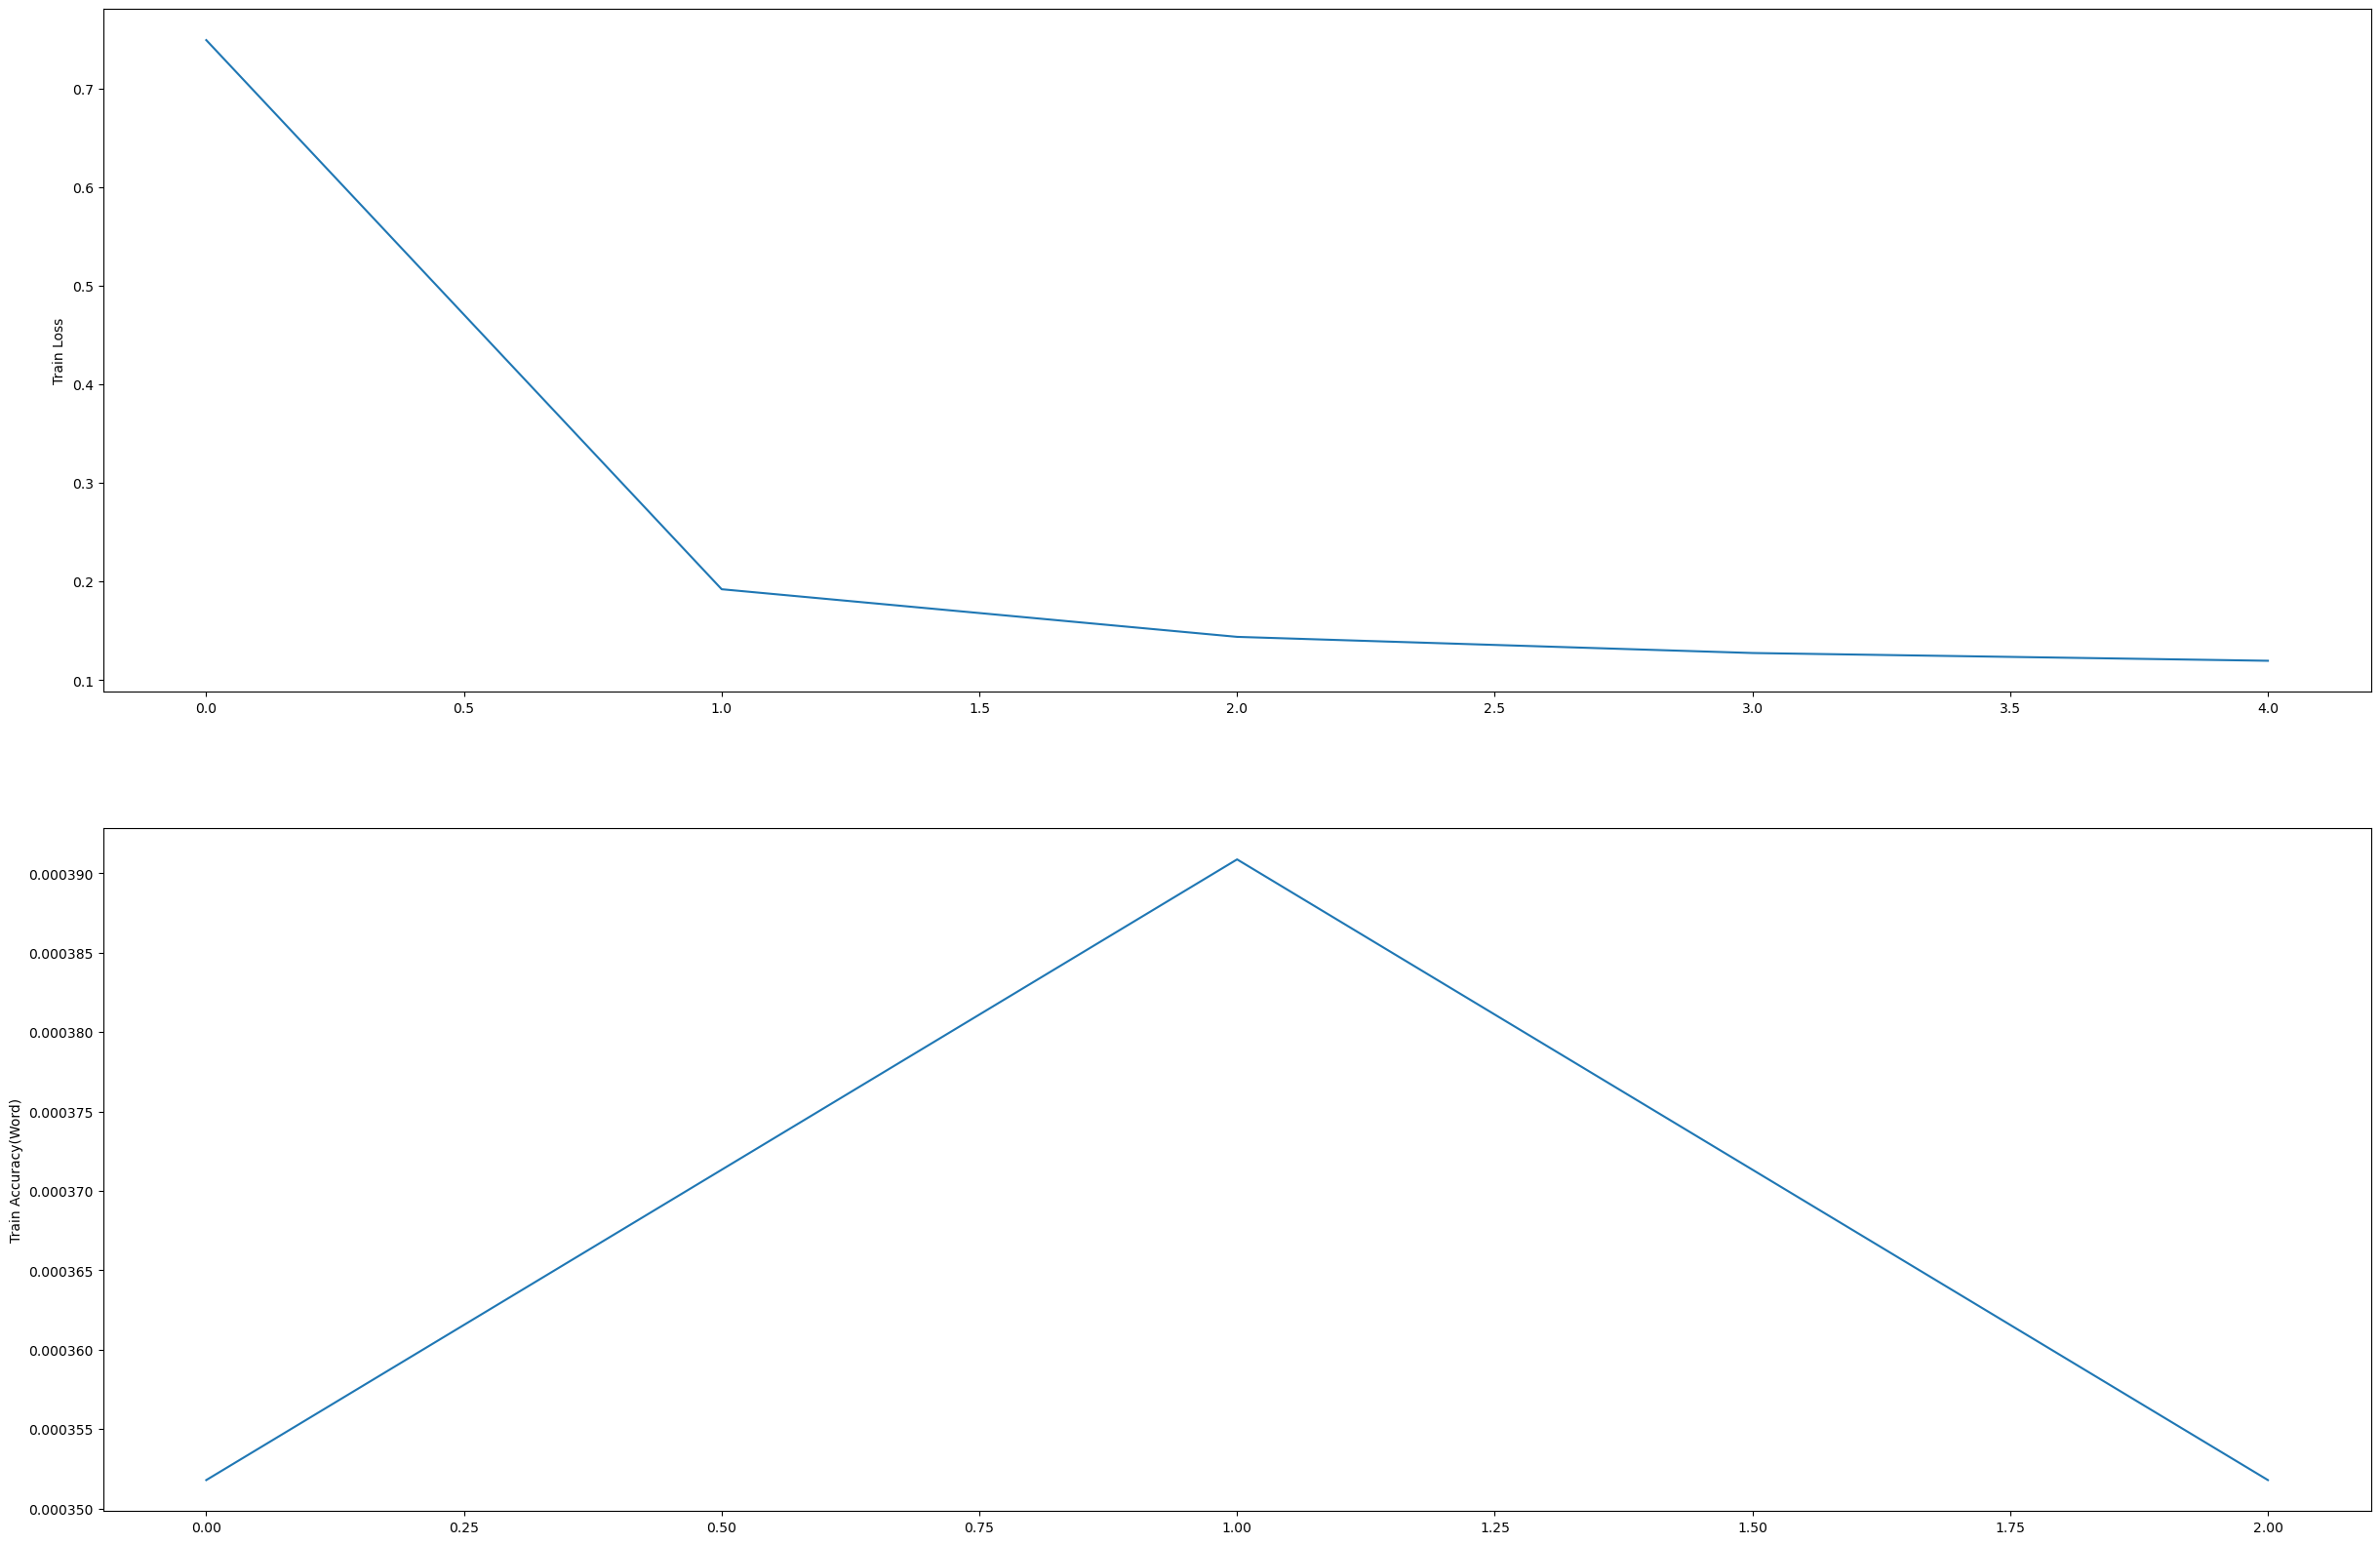

Train Loss,█▂▁▁▁
Val_Accuracy,▁
Val_Loss,█▂▁▄▅
Train Loss,0.11969
Val_Accuracy,0.33571
Val_Loss,0.37501


wandb: Agent Starting Run: p756o84w with config:
wandb: 	bidirectional: False
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 2
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 3
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.5


1m 8s (- 2m 17s) (1 33%) 0.8258153
2m 9s (- 1m 4s) (2 66%) 0.3585882
3m 10s (- 1m 35s) (2 66%) 0.3272620
4m 11s (- 0m 0s) (3 100%) 0.3036100
5m 11s (- 0m 0s) (3 100%) 0.2976369
[0.00019543846619891726, 0.00027361385267848416, 0.00017589461957902554]
Val loss = 0.549139678478241
Word-level-accuracy on val set = 0.18410041841004185


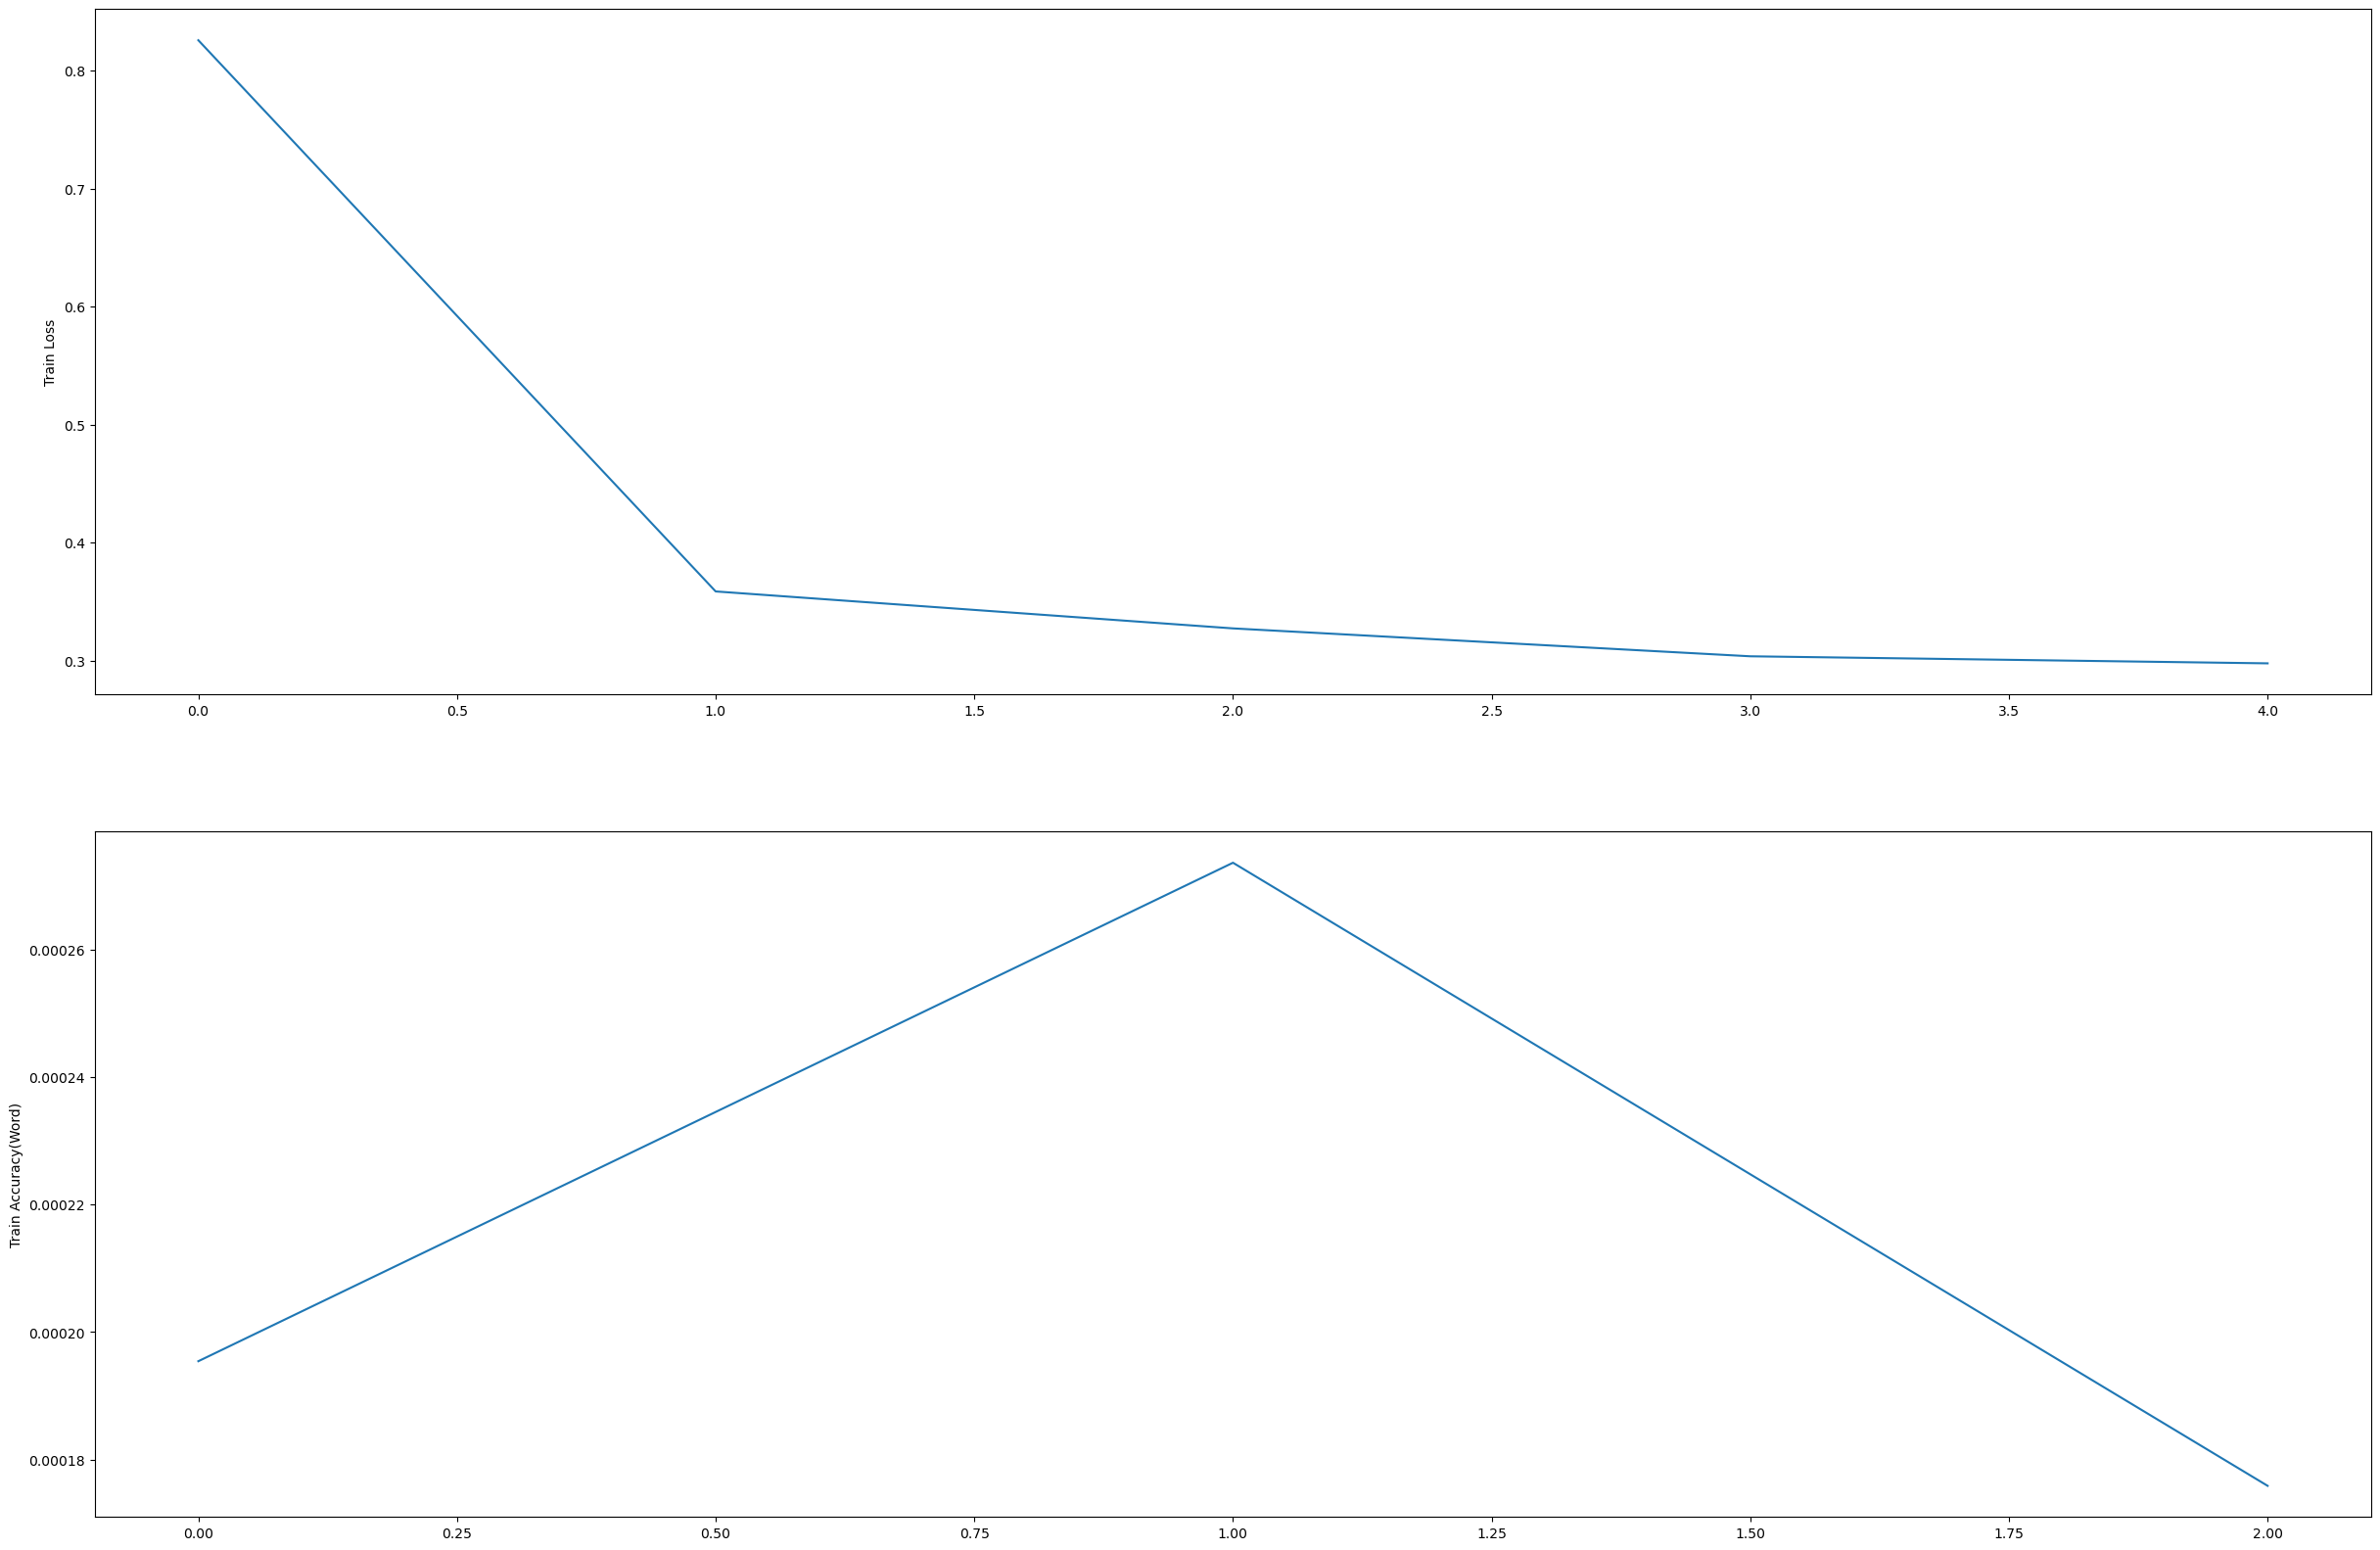

Train Loss,█▂▁▁▁
Val_Accuracy,▁
Val_Loss,▆▂▃█▁
Train Loss,0.29764
Val_Accuracy,0.1841
Val_Loss,0.38123


wandb: Agent Starting Run: zwe6sicm with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


2m 8s (- 8m 33s) (1 20%) 0.5443762
4m 11s (- 6m 17s) (2 40%) 0.1947874
6m 15s (- 9m 23s) (2 40%) 0.1635032
8m 19s (- 5m 32s) (3 60%) 0.1573765
10m 23s (- 6m 55s) (3 60%) 0.1504555
12m 26s (- 3m 6s) (4 80%) 0.2857678
14m 30s (- 3m 37s) (4 80%) 0.2483538
16m 33s (- 0m 0s) (5 100%) 0.2411737
18m 37s (- 0m 0s) (5 100%) 0.2330017
[0.000214982312818809, 0.00031270154591826765, 0.00025407000605859244, 0.0003908769323978345, 0.00029315769929837593]
Val loss = 0.4285752773284912
Word-level-accuracy on val set = 0.3691853310361802


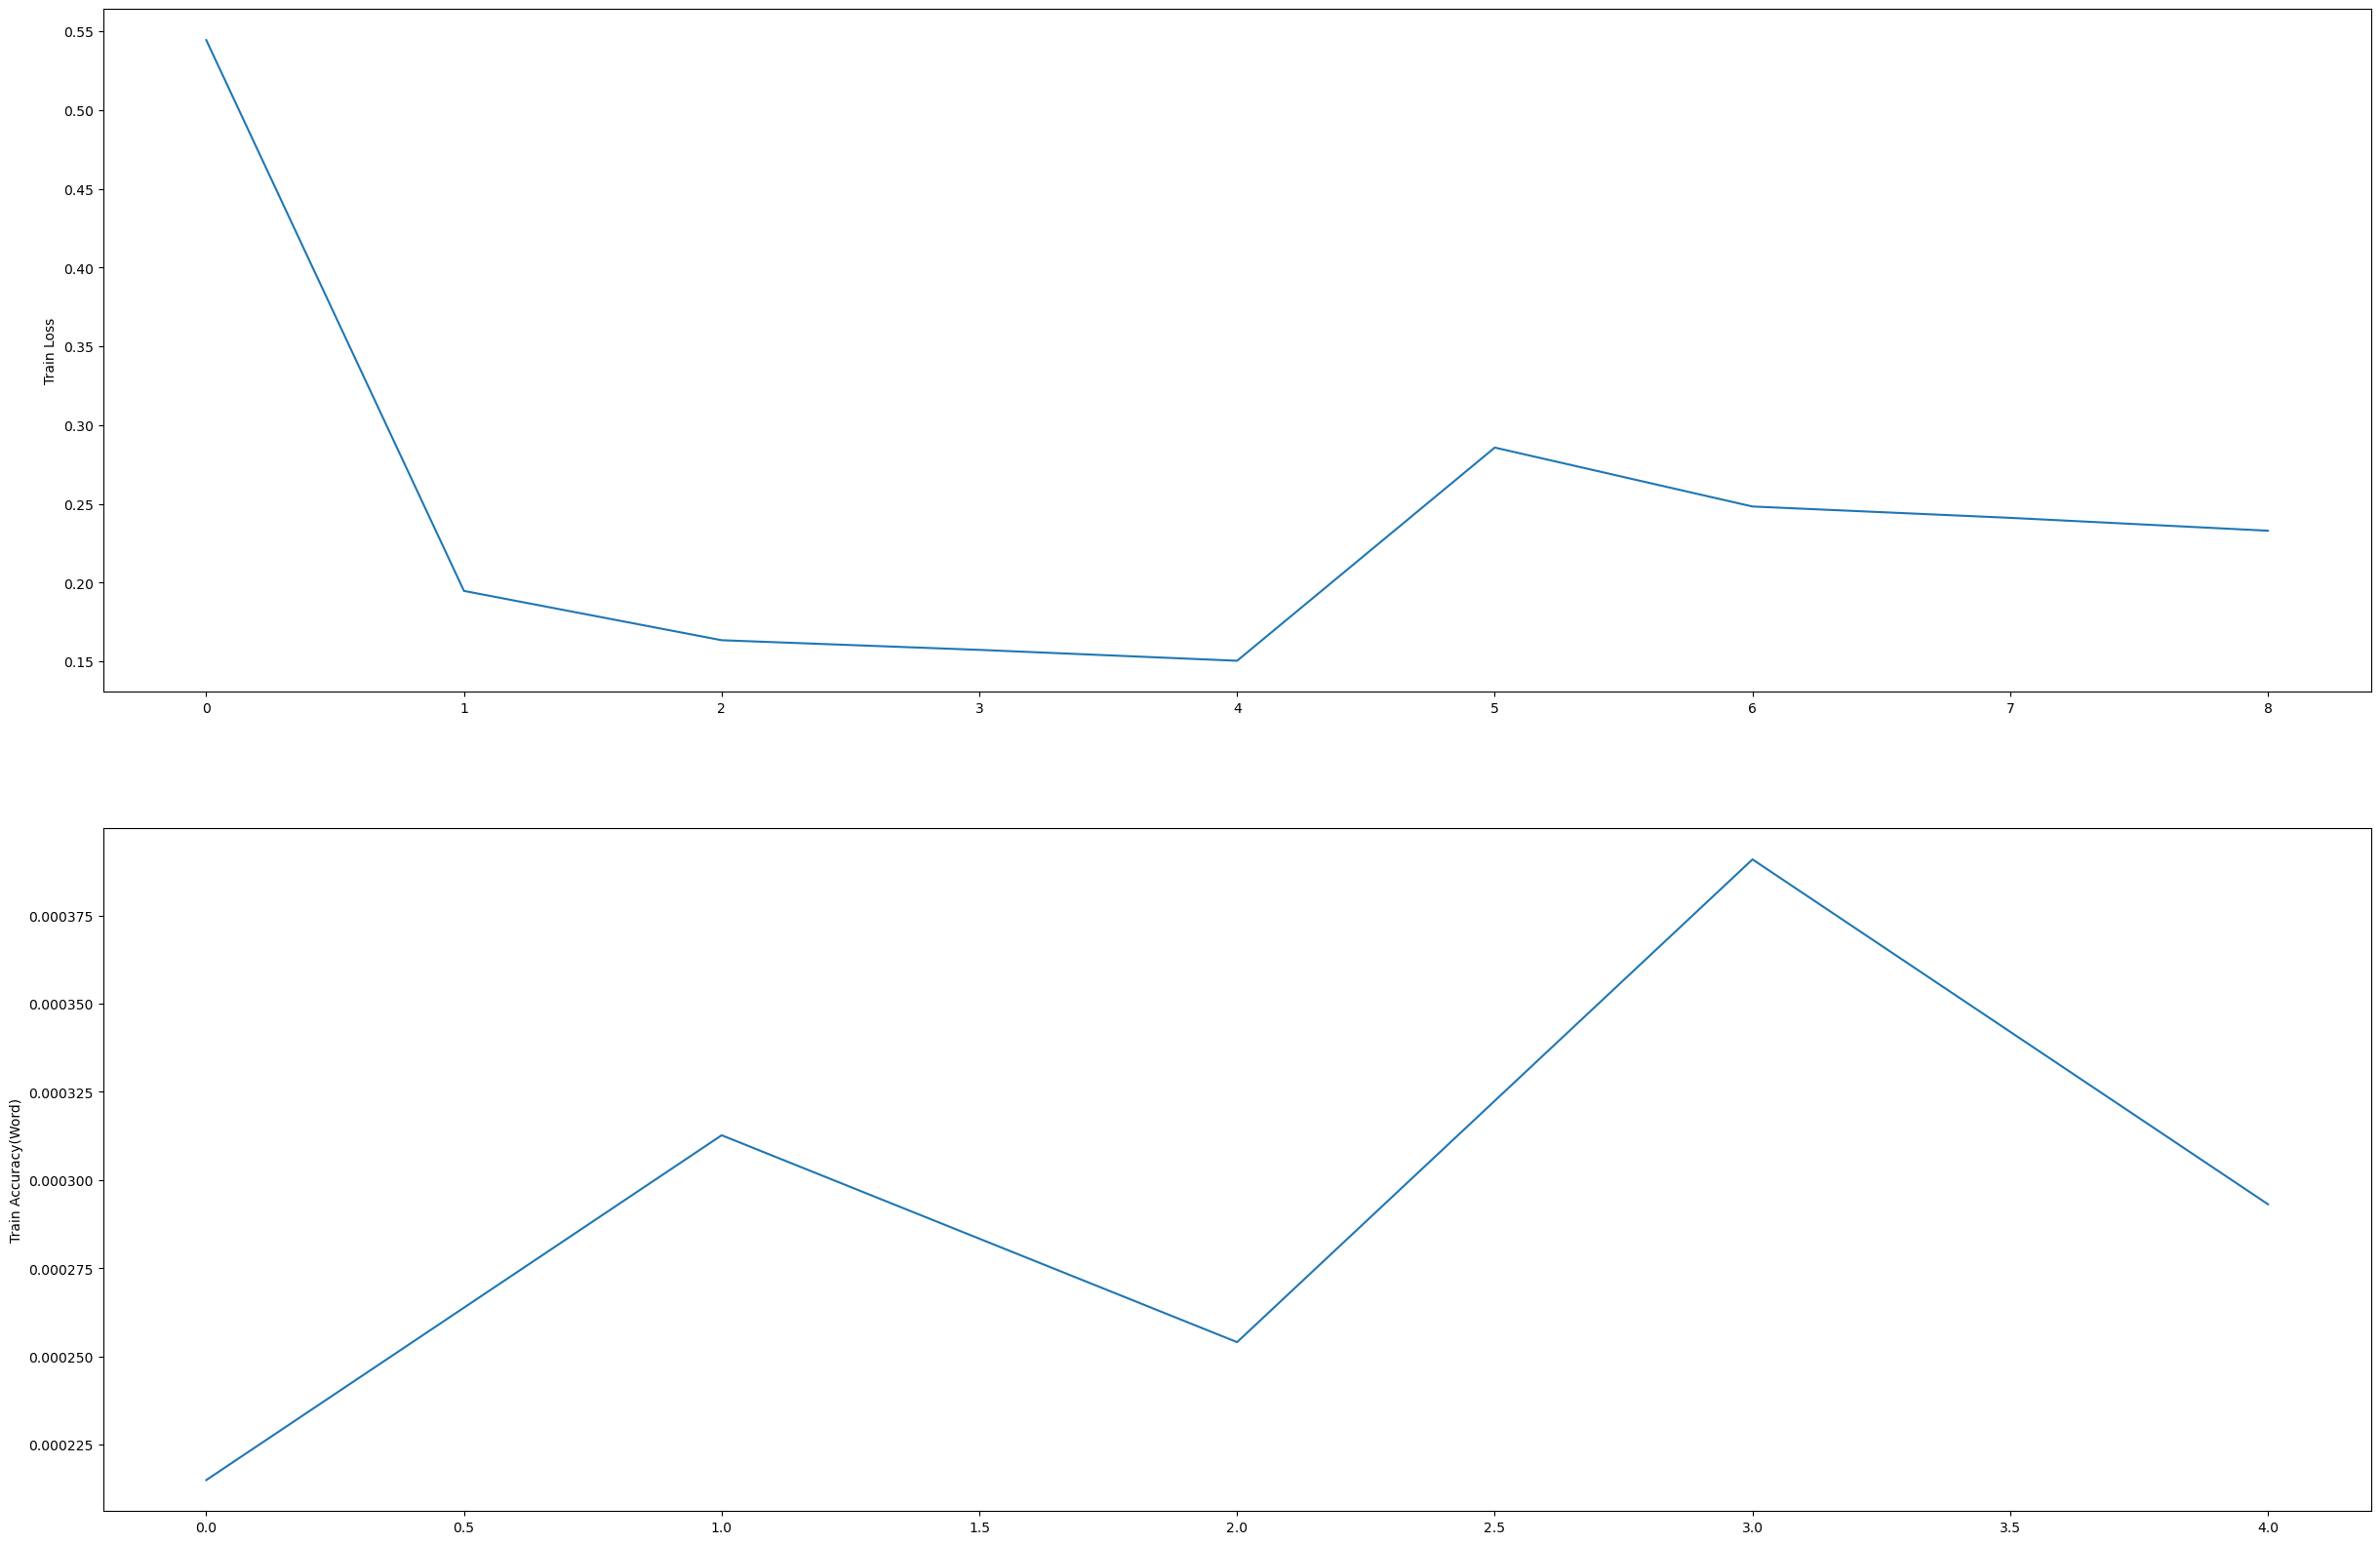

Train Loss,█▂▁▁▁▃▃▃▂
Val_Accuracy,▁
Val_Loss,█▆▂▁▃▁▂▁▁
Train Loss,0.233
Val_Accuracy,0.36919
Val_Loss,0.29377


wandb: Agent Starting Run: n65az6iz with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.4
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


2m 6s (- 8m 27s) (1 20%) 0.5661259
4m 10s (- 6m 15s) (2 40%) 0.1871284
6m 14s (- 9m 21s) (2 40%) 0.1513893
8m 18s (- 5m 32s) (3 60%) 0.1415467
10m 21s (- 6m 54s) (3 60%) 0.1341854
12m 25s (- 3m 6s) (4 80%) 0.2642516
14m 29s (- 3m 37s) (4 80%) 0.2372982
16m 33s (- 0m 0s) (5 100%) 0.2382520
18m 36s (- 0m 0s) (5 100%) 0.2309848
[0.0003517892391580511, 0.0003517892391580511, 0.0003517892391580511, 0.0003713330857779428, 0.0003908769323978345]
Val loss = 0.39401164650917053
Word-level-accuracy on val set = 0.39601279842480924


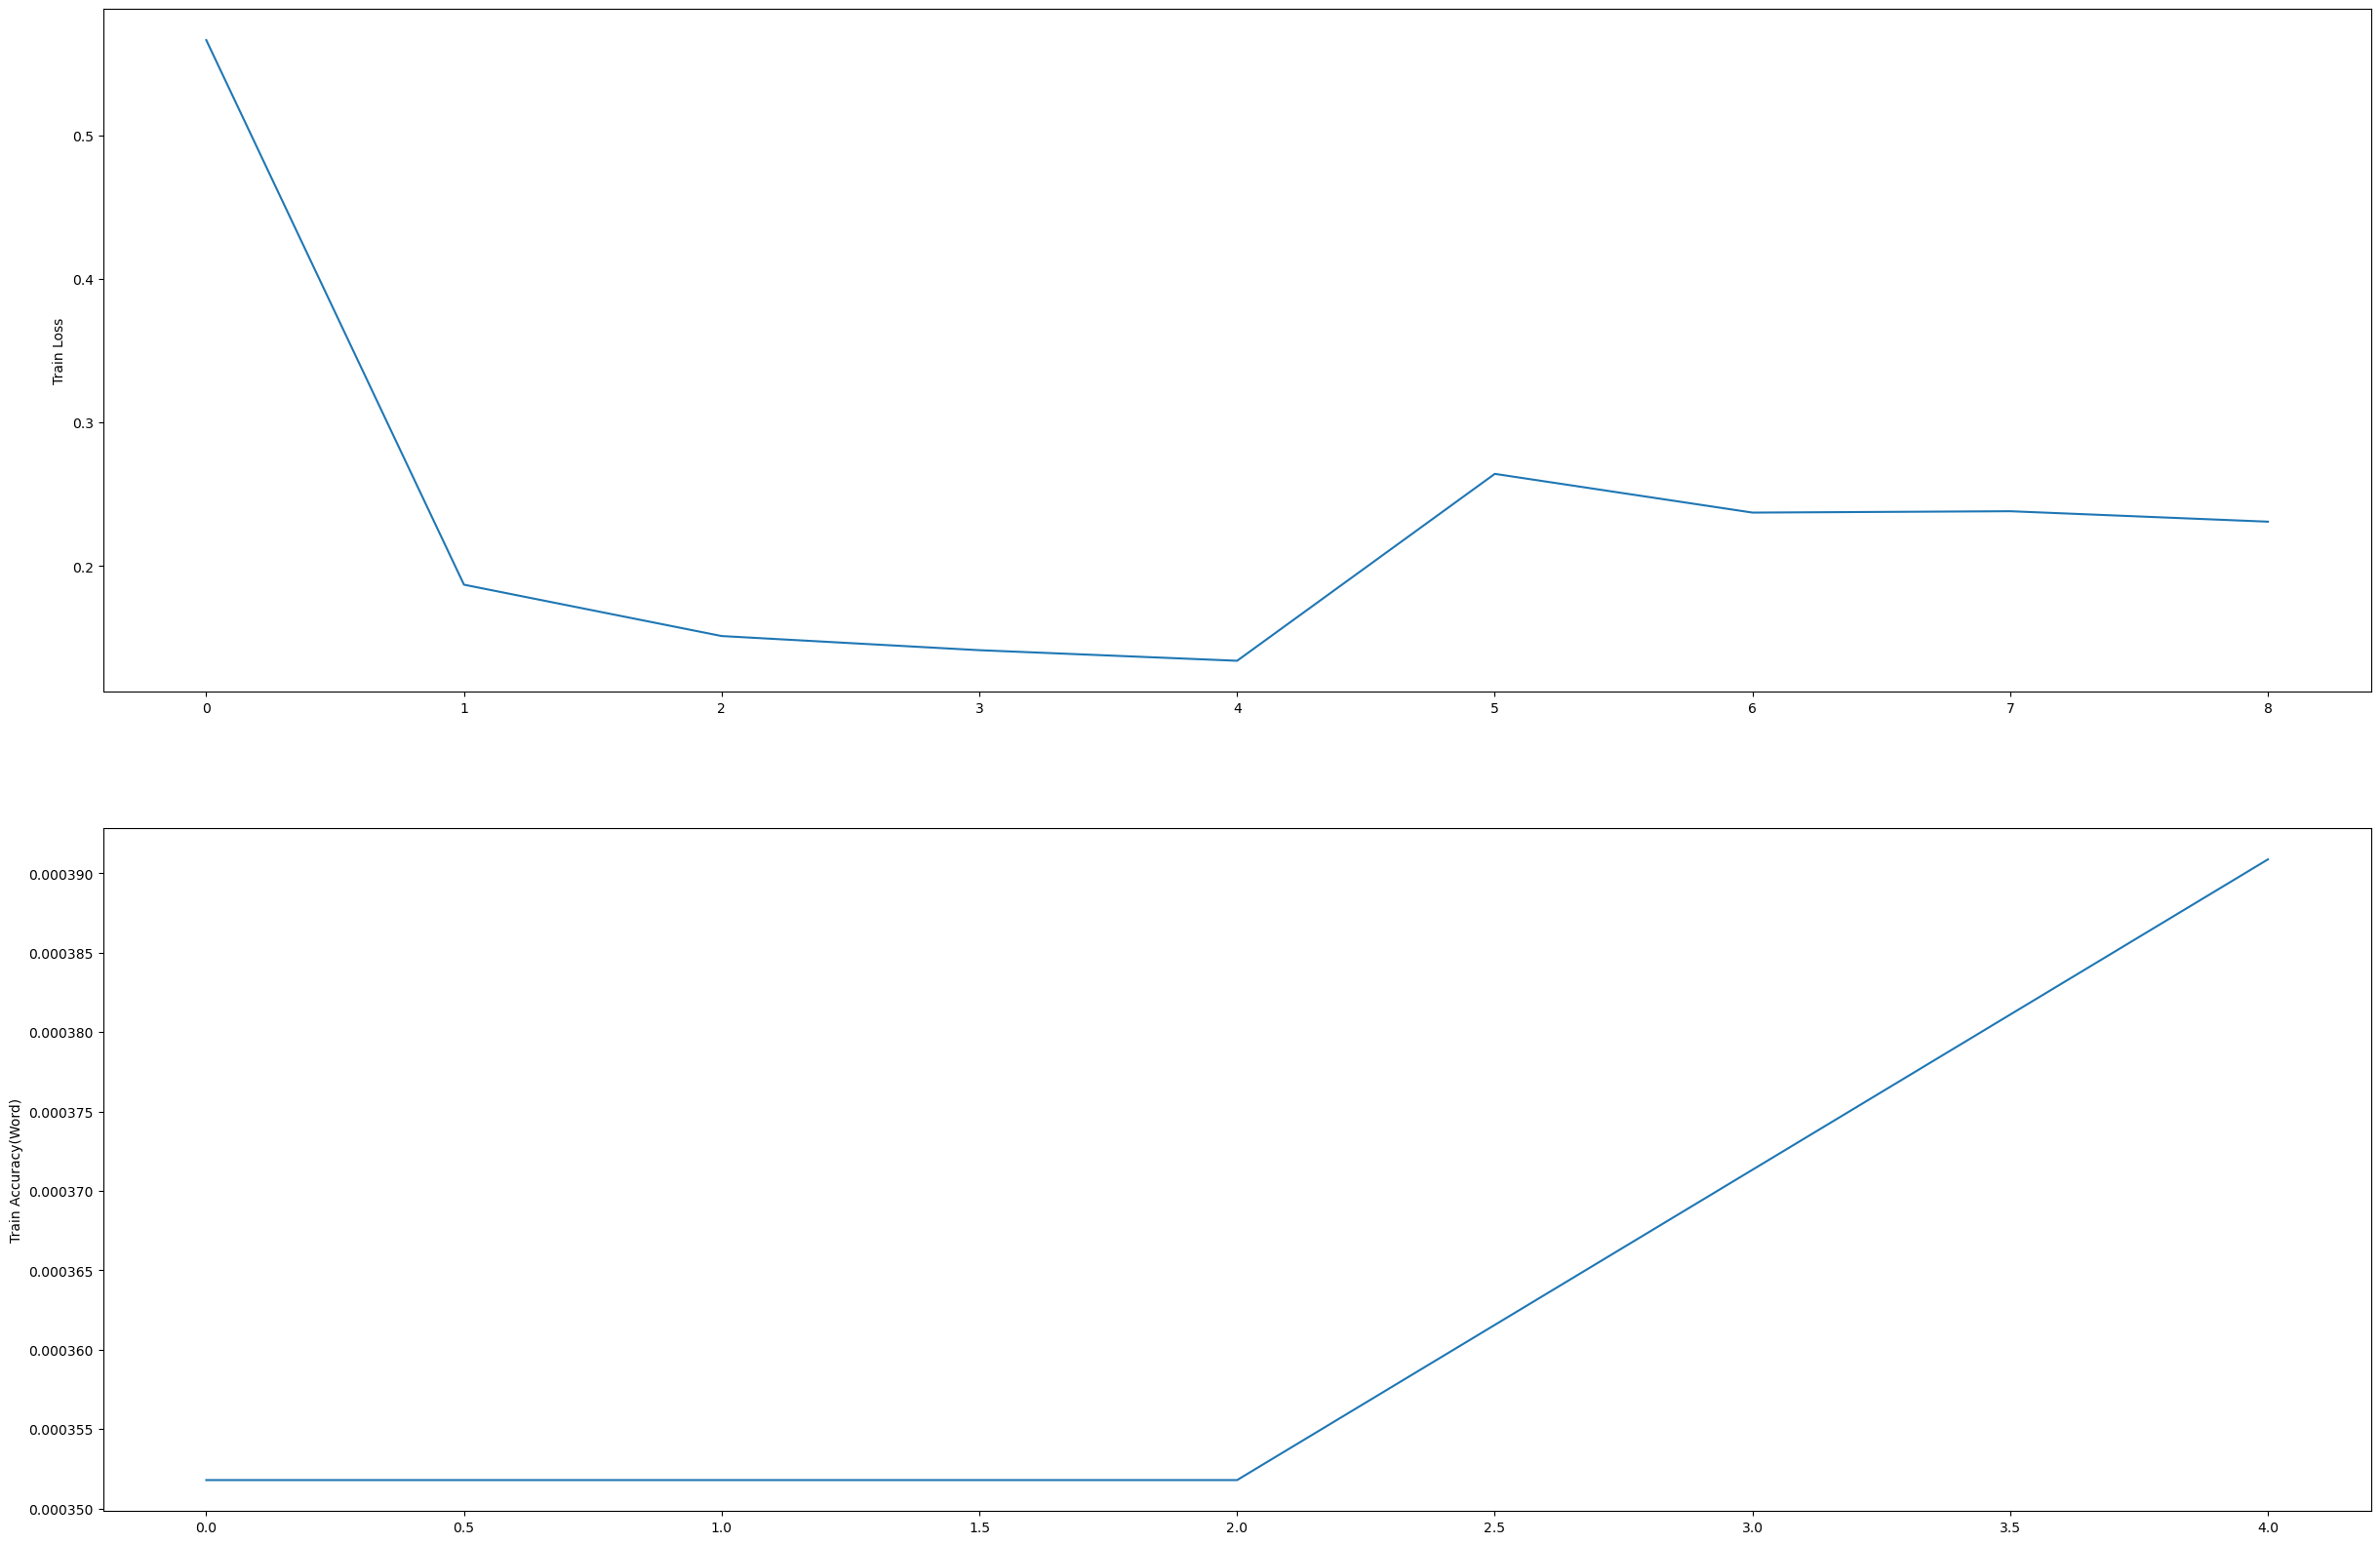

Train Loss,█▂▁▁▁▃▃▃▃
Val_Accuracy,▁
Val_Loss,█▇▃▇▇▂▁▄▃
Train Loss,0.23098
Val_Accuracy,0.39601
Val_Loss,0.30502


wandb: Agent Starting Run: m6oc0444 with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.4
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


2m 6s (- 8m 27s) (1 20%) 0.7469993
4m 10s (- 6m 15s) (2 40%) 0.2309942
6m 13s (- 9m 20s) (2 40%) 0.1537475
8m 17s (- 5m 31s) (3 60%) 0.1336696
10m 20s (- 6m 53s) (3 60%) 0.1240192
12m 23s (- 3m 5s) (4 80%) 0.2765214
14m 27s (- 3m 36s) (4 80%) 0.2384590
16m 30s (- 0m 0s) (5 100%) 0.2415959
18m 33s (- 0m 0s) (5 100%) 0.2308210
[0.00031270154591826765, 0.00027361385267848416, 0.00015635077295913382, 0.00044950847225750973, 0.0003517892391580511]
Val loss = 0.37564602494239807
Word-level-accuracy on val set = 0.41299532365247354


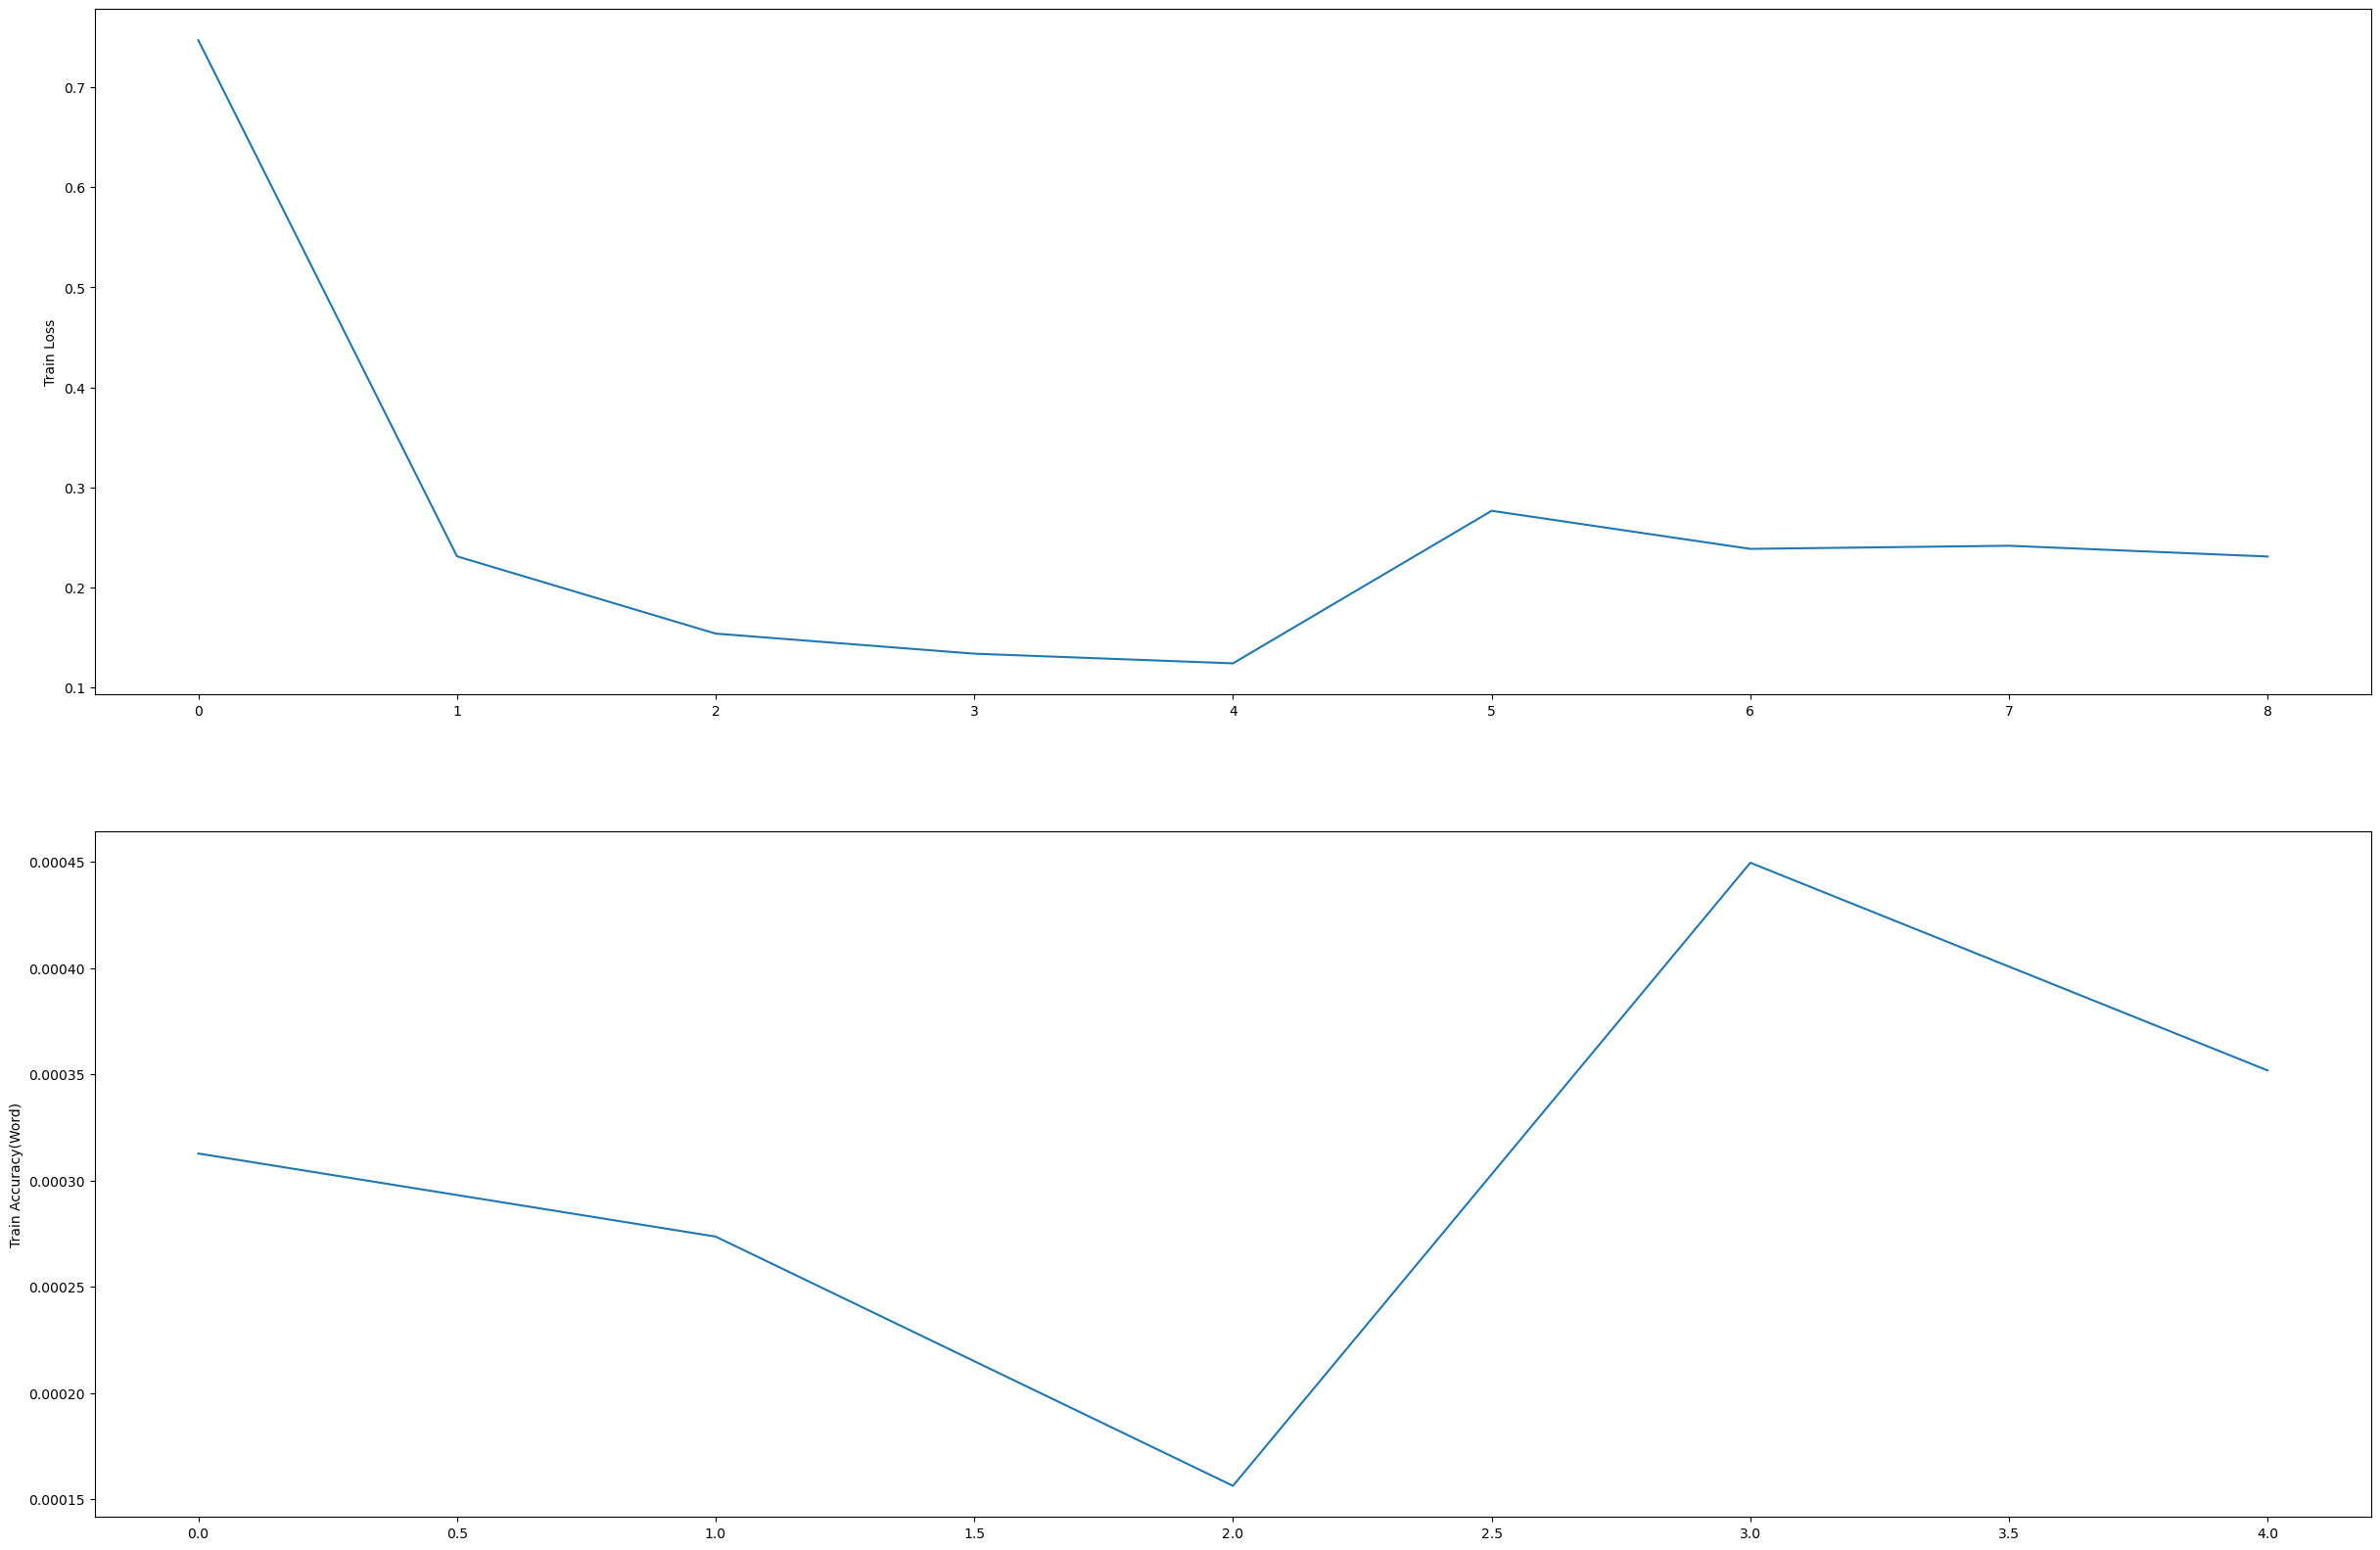

Train Loss,█▂▁▁▁▃▂▂▂
Val_Accuracy,▁
Val_Loss,█▅▄▅▄▂▁▂▂
Train Loss,0.23082
Val_Accuracy,0.413
Val_Loss,0.31444


wandb: Agent Starting Run: yoljscee with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_embedding: 128
wandb: 	dec_layers: 3
wandb: 	dropout: 0.4
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


2m 14s (- 8m 58s) (1 20%) 1.0891491
4m 25s (- 6m 38s) (2 40%) 0.7056246
6m 37s (- 9m 56s) (2 40%) 0.6441665
8m 49s (- 5m 52s) (3 60%) 0.6230000
11m 0s (- 7m 20s) (3 60%) 0.6130141
13m 12s (- 3m 18s) (4 80%) 0.6931040
15m 24s (- 3m 51s) (4 80%) 0.6639182
17m 35s (- 0m 0s) (5 100%) 0.5128562
19m 47s (- 0m 0s) (5 100%) 0.4845354
[1.9543846619891728e-05, 0.0, 1.9543846619891728e-05, 1.9543846619891728e-05, 1.9543846619891728e-05]
Val loss = 0.6285858750343323
Word-level-accuracy on val set = 0.08122077282795964


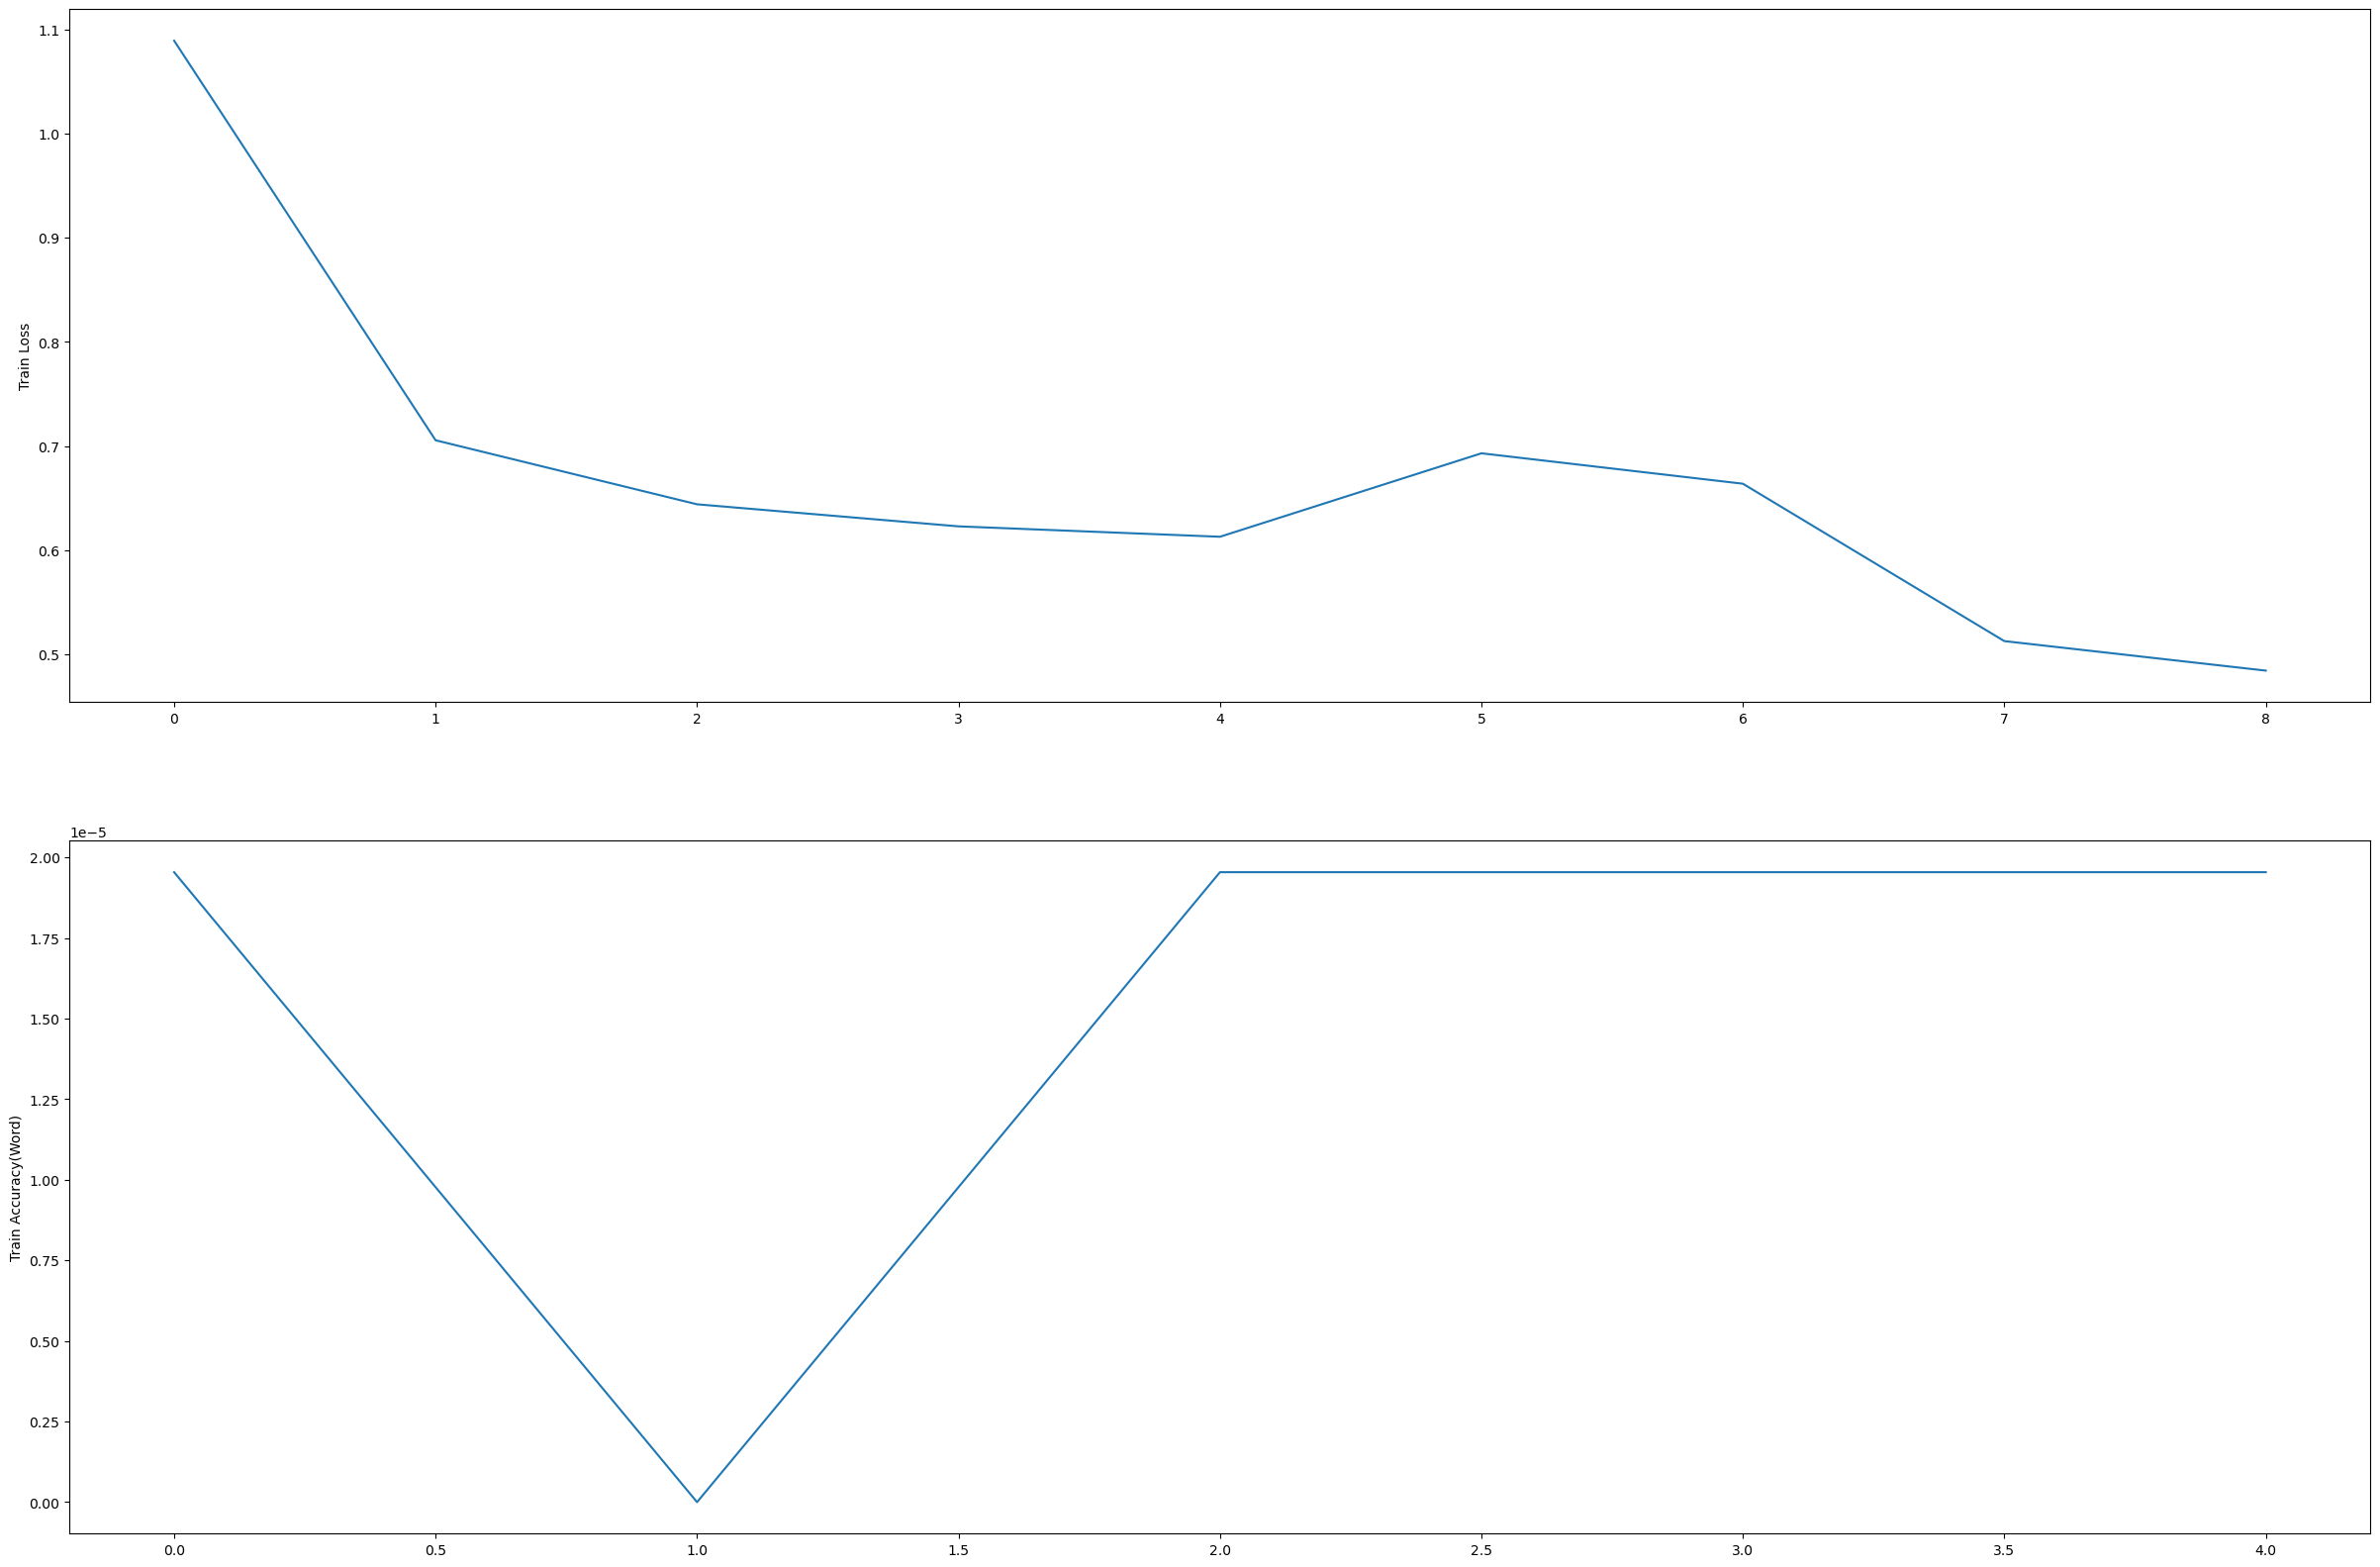

Train Loss,█▄▃▃▂▃▃▁▁
Val_Accuracy,▁
Val_Loss,█▆▃▆▄▄▄▁▁
Train Loss,0.48454
Val_Accuracy,0.08122
Val_Loss,0.46622


wandb: Agent Starting Run: k5fy1iui with config:
wandb: 	bidirectional: False
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.4
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


1m 8s (- 4m 35s) (1 20%) 1.0492296
2m 12s (- 3m 18s) (2 40%) 0.5539735
3m 15s (- 4m 53s) (2 40%) 0.4097994
4m 19s (- 2m 53s) (3 60%) 0.3081305
5m 22s (- 3m 34s) (3 60%) 0.2596950
6m 24s (- 1m 36s) (4 80%) 0.3956313
7m 26s (- 1m 51s) (4 80%) 0.3262411
8m 29s (- 0m 0s) (5 100%) 0.2787879
9m 31s (- 0m 0s) (5 100%) 0.2645878
[5.863153985967518e-05, 0.00011726307971935036, 0.00013680692633924208, 0.00027361385267848416, 0.00023452615943870072]
Val loss = 0.43492618203163147
Word-level-accuracy on val set = 0.3234063499876938


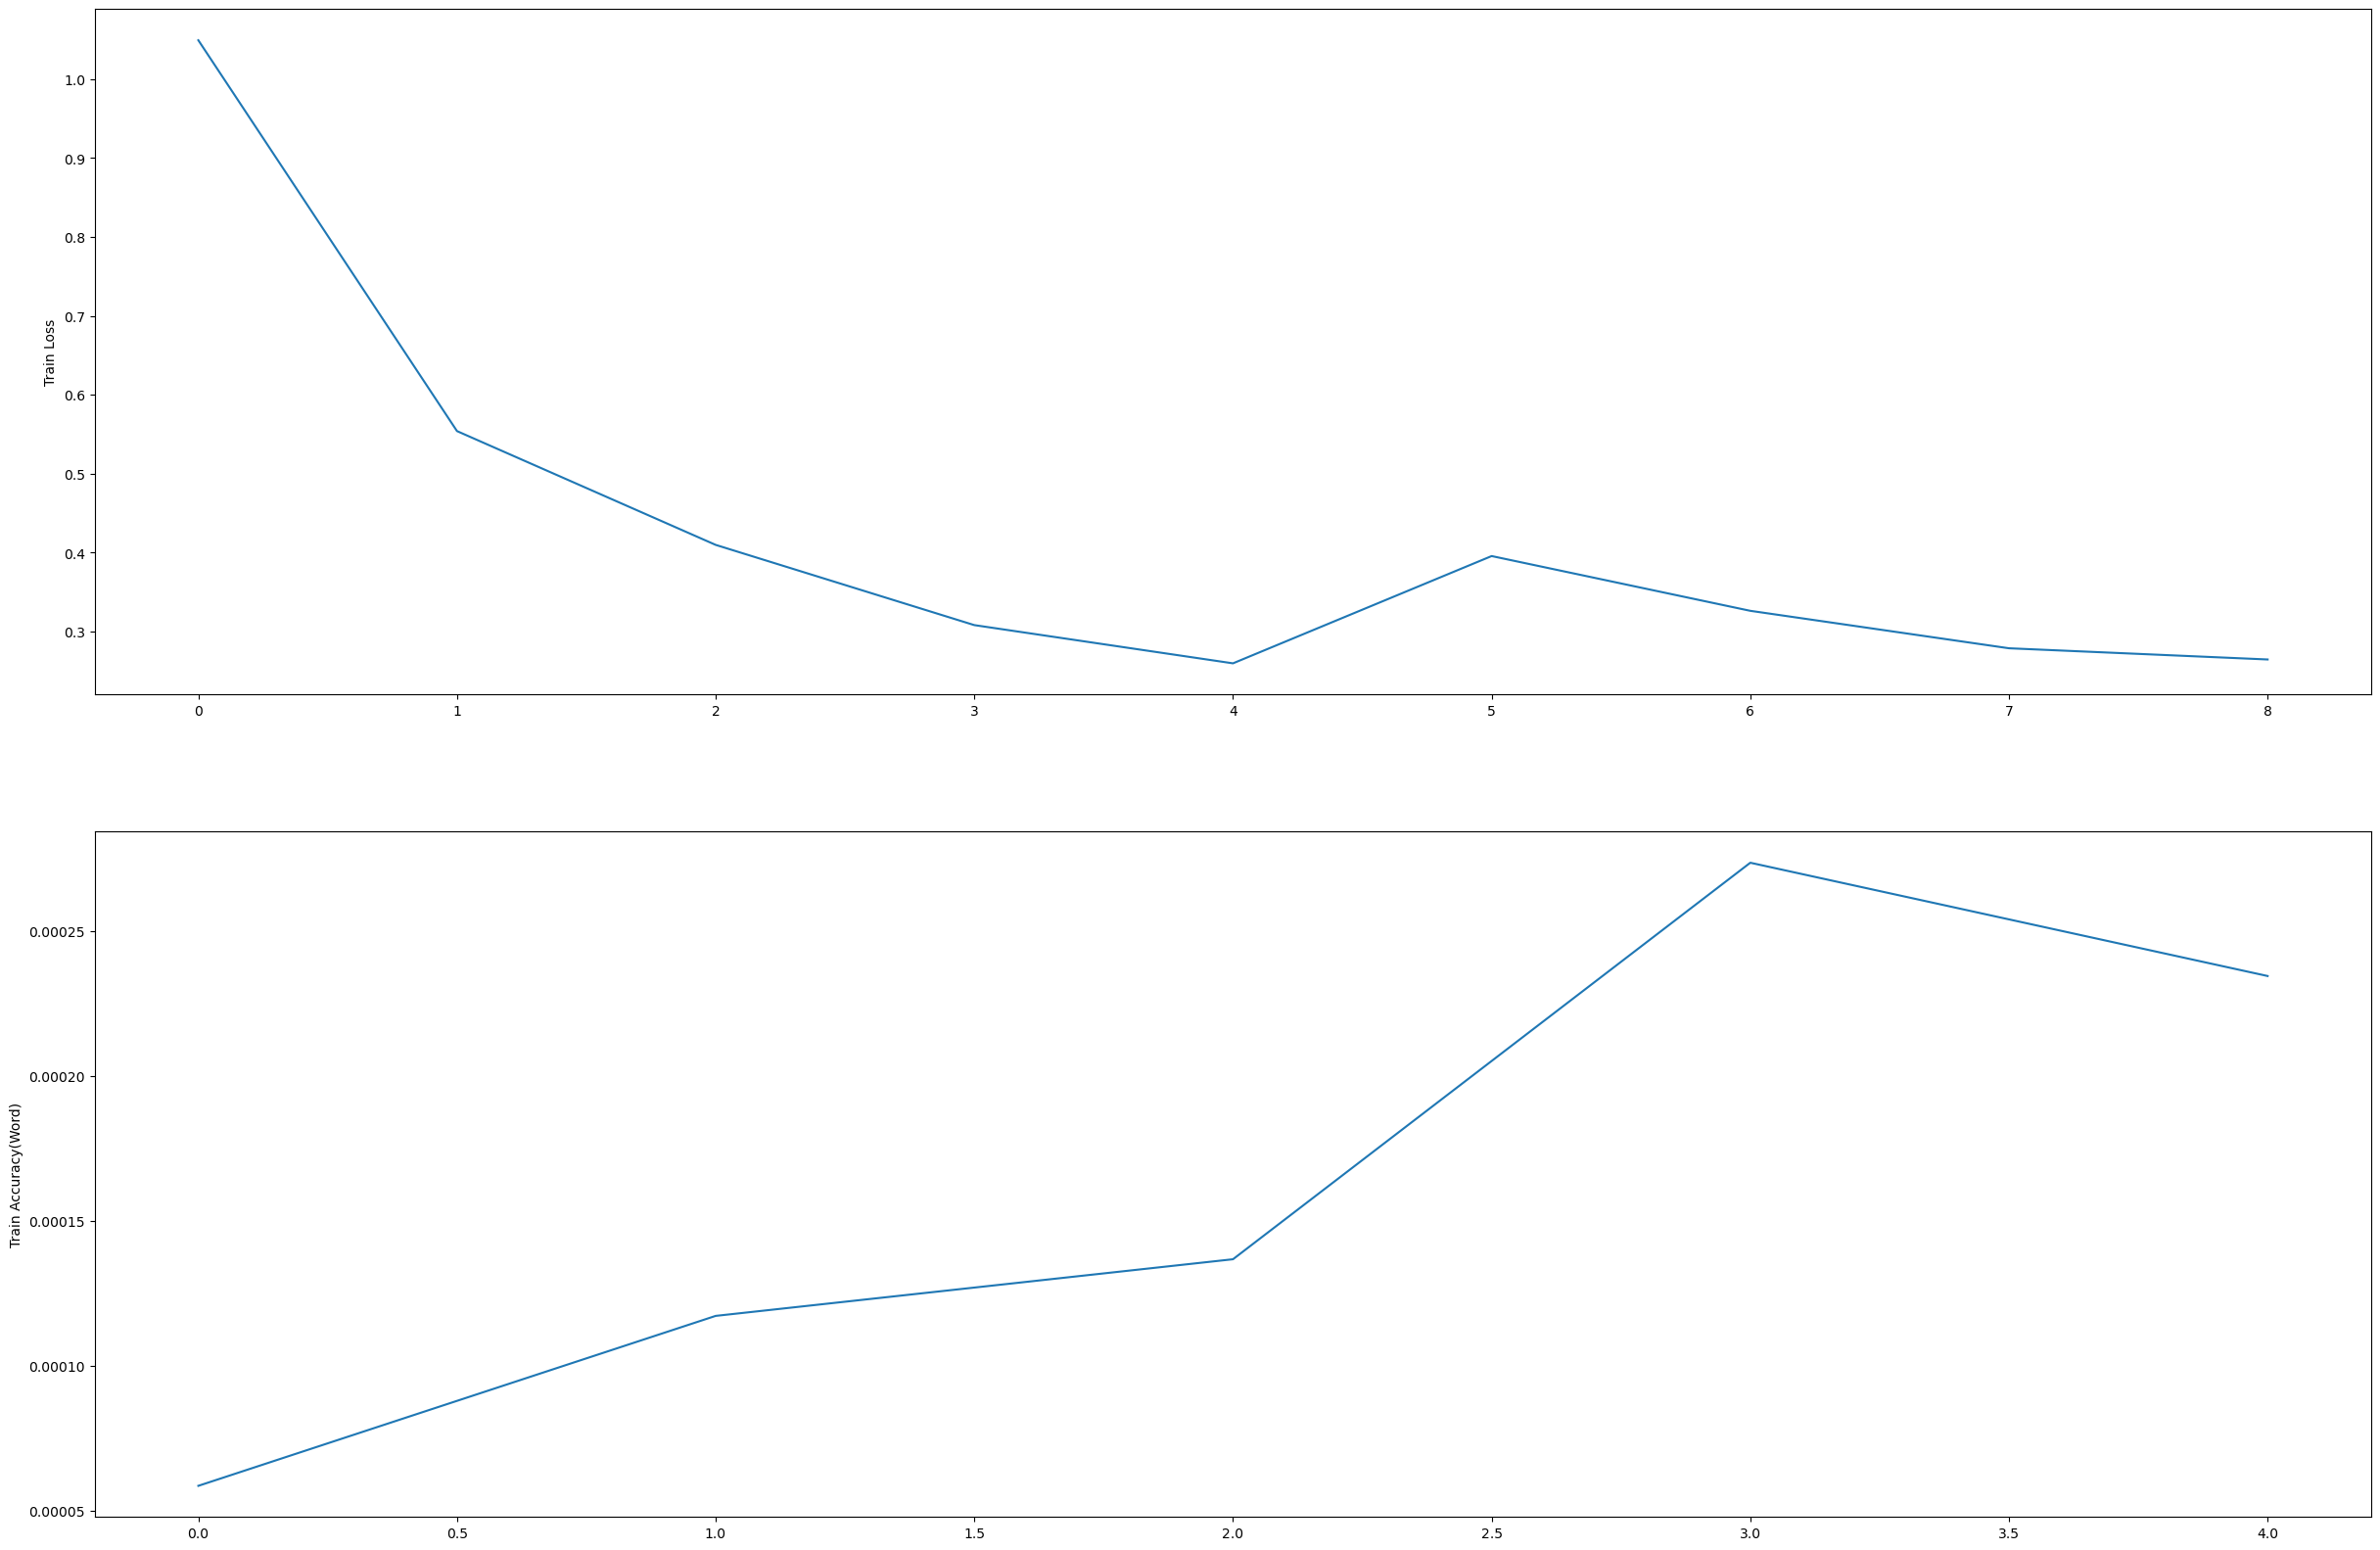

Train Loss,█▄▂▁▁▂▂▁▁
Val_Accuracy,▁
Val_Loss,█▅▄▄▃▂▁▁▁
Train Loss,0.26459
Val_Accuracy,0.32341
Val_Loss,0.32158


wandb: Agent Starting Run: 7npgqrm0 with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 3
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


1m 55s (- 3m 50s) (1 33%) 0.5884255
3m 48s (- 1m 54s) (2 66%) 0.1671458
5m 42s (- 2m 51s) (2 66%) 0.1350890
7m 36s (- 0m 0s) (3 100%) 0.1304646
9m 29s (- 0m 0s) (3 100%) 0.1208374
[0.00015635077295913382, 0.0003713330857779428, 0.00029315769929837593]
Val loss = 0.3043226897716522
Word-level-accuracy on val set = 0.41521043563869064


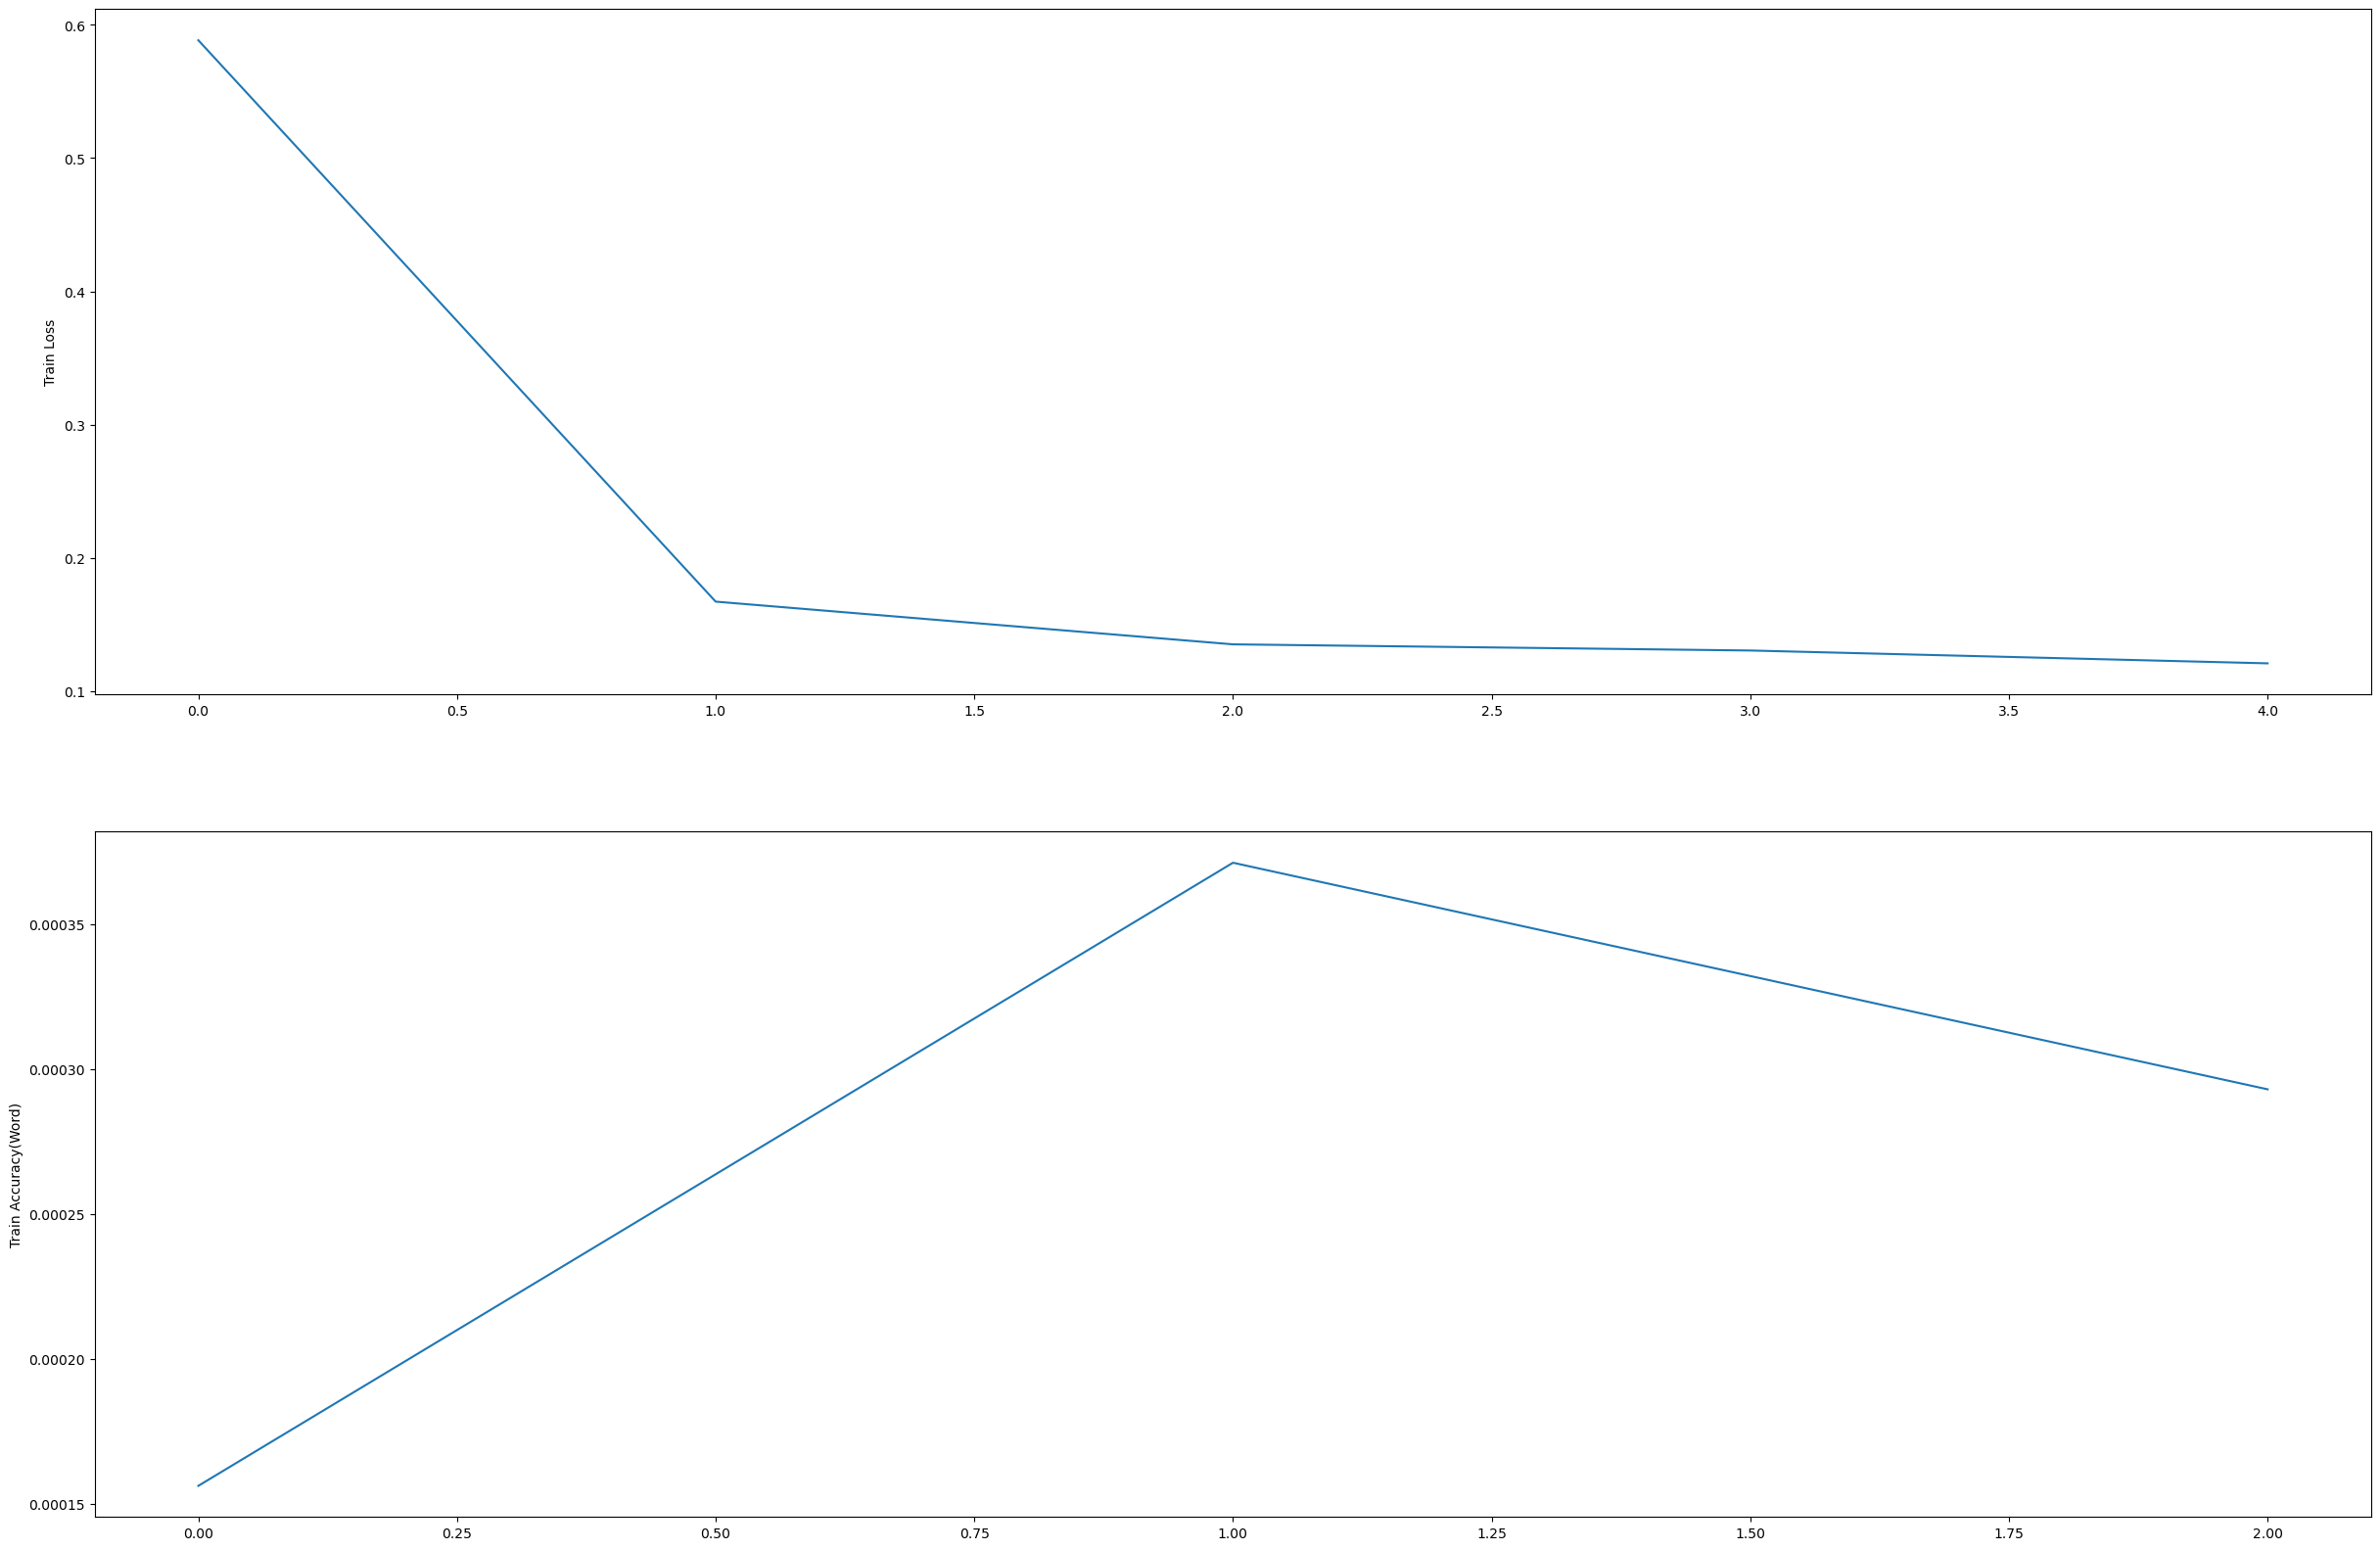

Train Loss,█▂▁▁▁
Val_Accuracy,▁
Val_Loss,▇██▁▁
Train Loss,0.12084
Val_Accuracy,0.41521
Val_Loss,0.31996


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7wgne6on with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


2m 4s (- 8m 19s) (1 20%) 0.5396813
4m 7s (- 6m 11s) (2 40%) 0.1572098
6m 11s (- 9m 16s) (2 40%) 0.1227100
8m 14s (- 5m 29s) (3 60%) 0.1174602
10m 17s (- 6m 51s) (3 60%) 0.1085466
12m 20s (- 3m 5s) (4 80%) 0.2385075
14m 23s (- 3m 35s) (4 80%) 0.2037259
16m 25s (- 0m 0s) (5 100%) 0.2050132
18m 28s (- 0m 0s) (5 100%) 0.1942614
[0.0003713330857779428, 0.0003713330857779428, 0.000429964625637618, 0.00033224539253815937, 0.00033224539253815937]
Val loss = 0.3807357847690582
Word-level-accuracy on val set = 0.43883829682500614


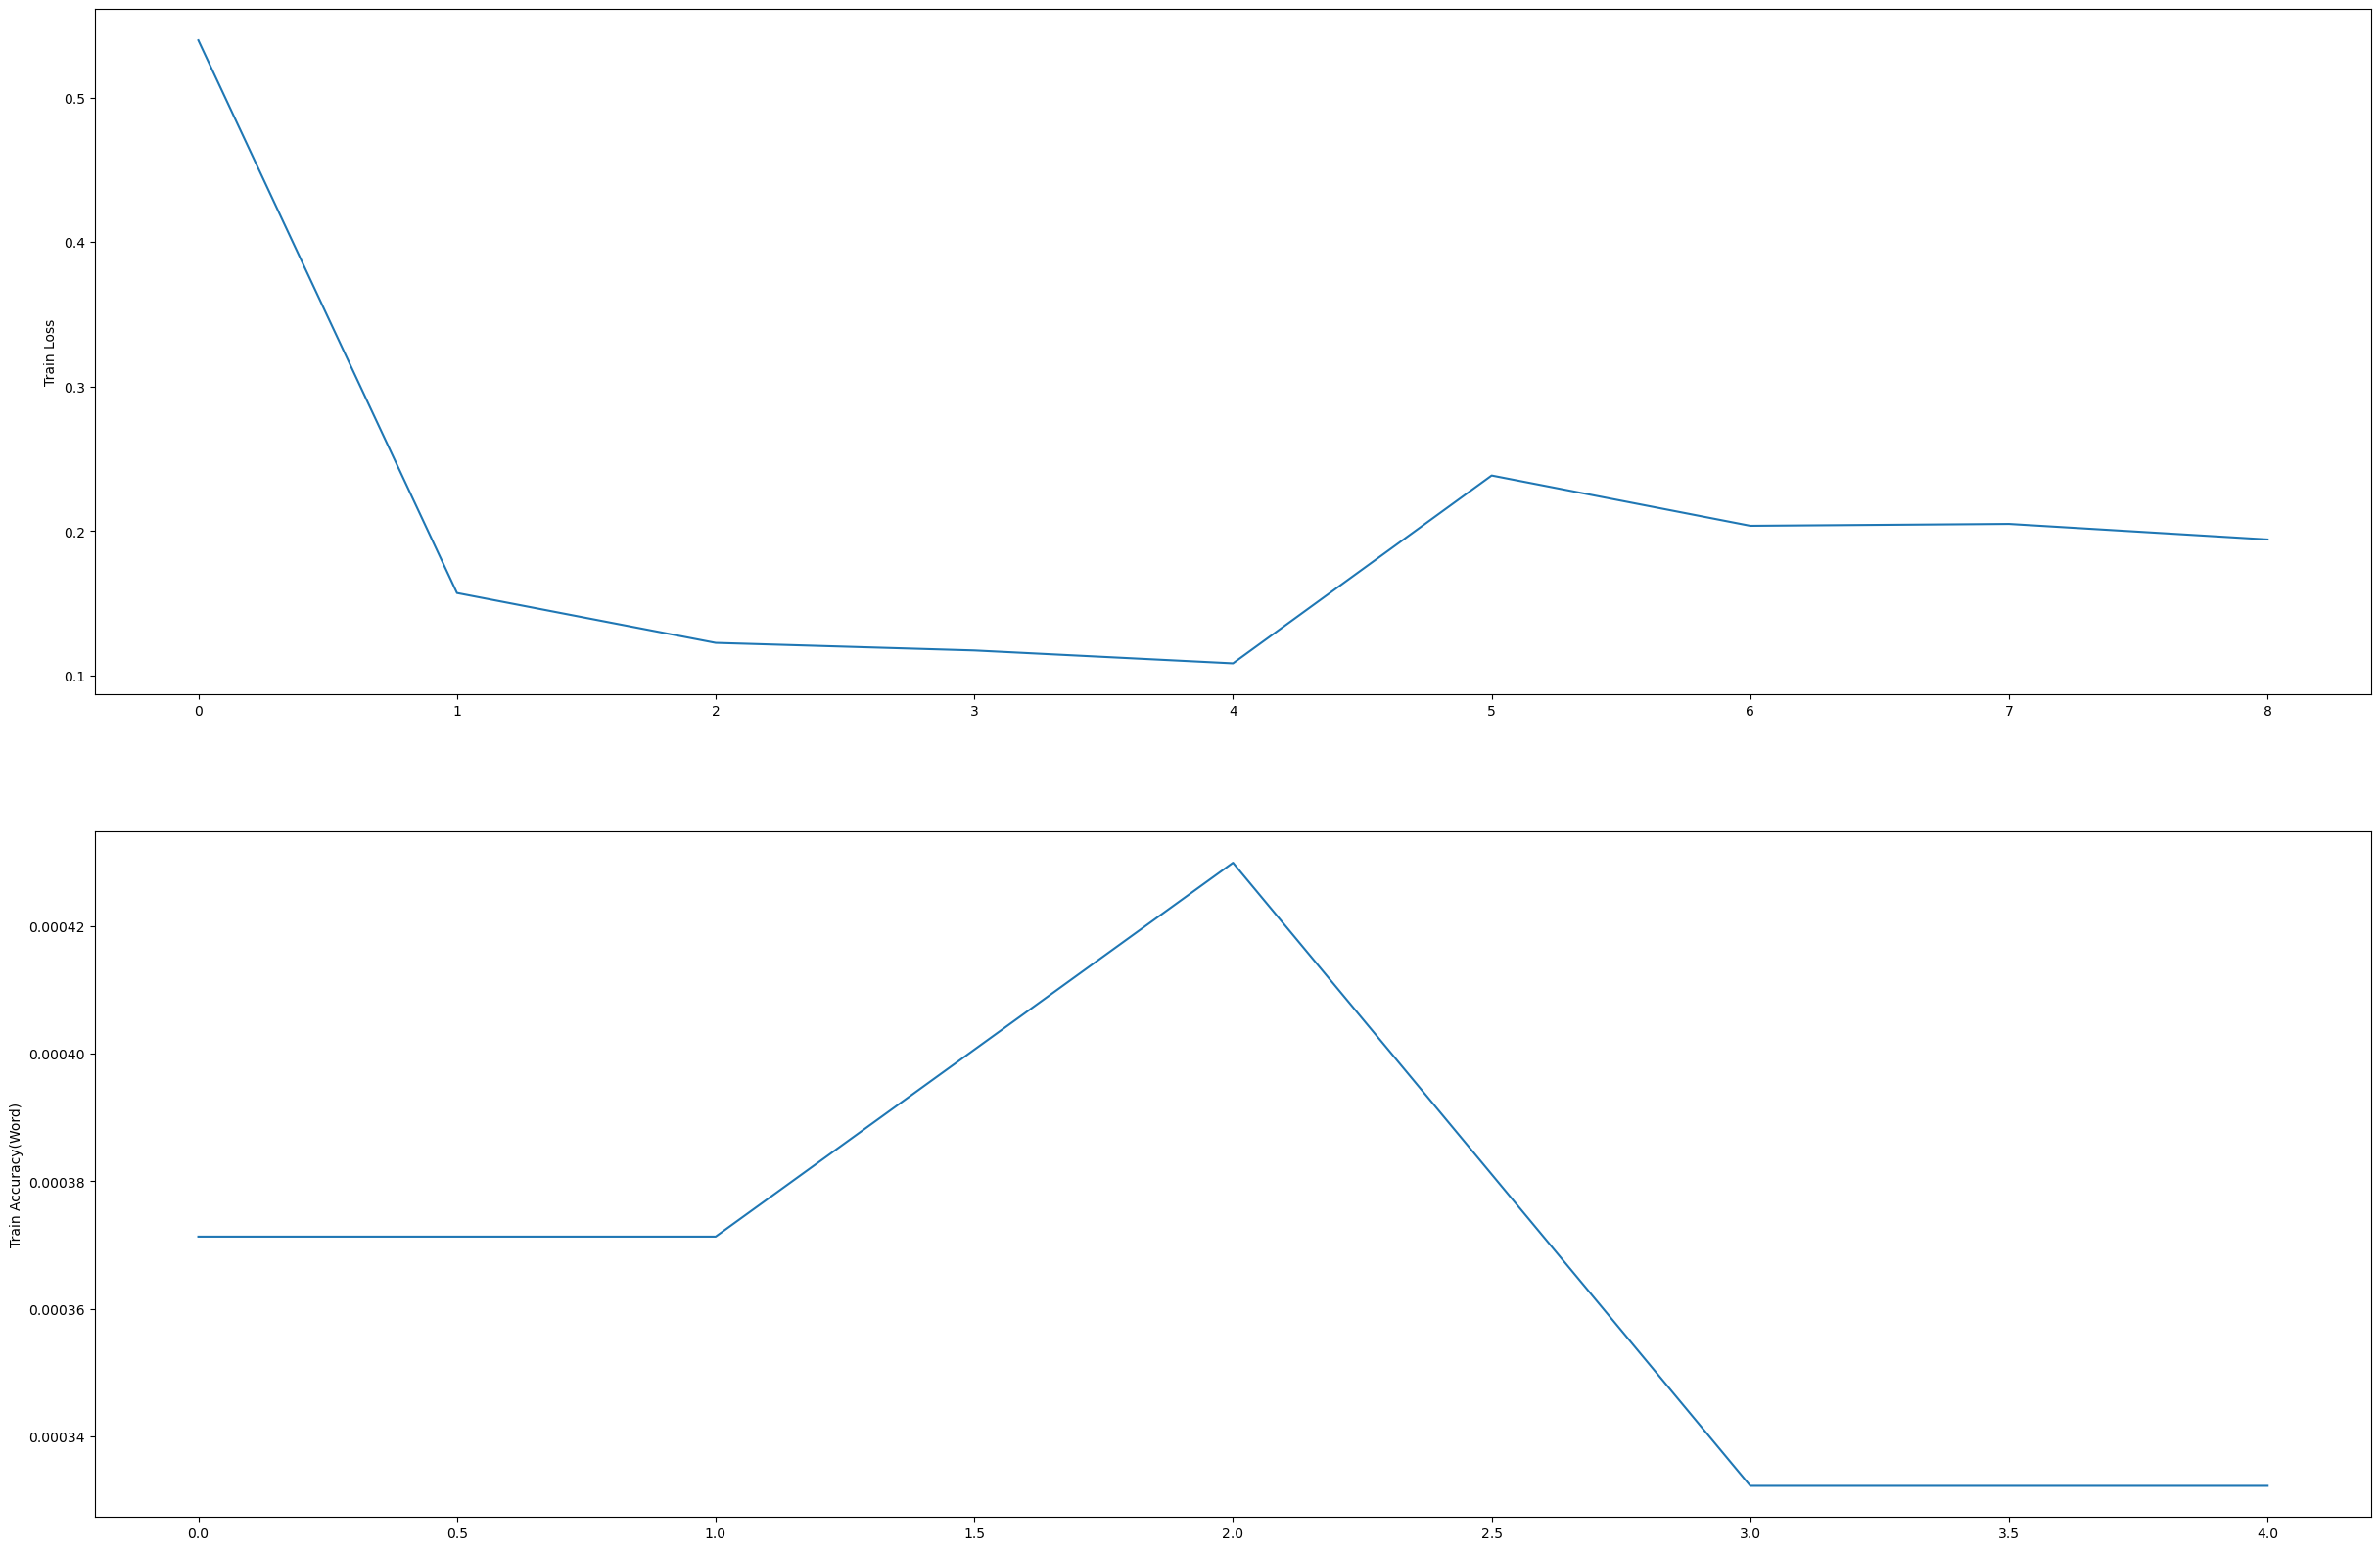

Train Loss,█▂▁▁▁▃▃▃▂
Val_Accuracy,▁
Val_Loss,▆▇▄▃█▁▂▂▃
Train Loss,0.19426
Val_Accuracy,0.43884
Val_Loss,0.3289


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a83oeixj with config:
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_embedding: 256
wandb: 	dec_layers: 3
wandb: 	dropout: 0.25
wandb: 	enc_embedding: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_size: 512
wandb: 	optimiser: adam
wandb: 	teacher_forcing_ratio: 0.7


2m 4s (- 8m 18s) (1 20%) 0.6813849


In [ ]:

sweep_config = {
    'method': 'bayes',
    'name' : 'Hyperparameter Tuning with Attention-Bayesian'
}

metric = {
    'name': 'Val_Accuracy',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric


parameters_dict = {
    'optimiser': {
        'values': ['adam']
        },
    'teacher_forcing_ratio':{
         'values':[0.5,0.7]
        },
    'bidirectional':{
         'values':[True, False]
        },
    'enc_embedding': {
        'values': [128,256]
        },
    'dec_embedding': {
        'values': [128,256]
        },
    'epochs': {
          'values': [3,5]
        },
    'hidden_size': {
          'values': [512]
        },
    'enc_layers': {
          'values': [2,3]
        },
    'dec_layers': {
          'values': [2,3]
        },
    'dropout': {
          'values': [0.25,0.4]
        },
    'cell_type': {
          'values': ['gru','lstm']
        }
    }

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="CS6910 Assignment 3")


def train_sweep(config=None):
  with wandb.init(config=config) as run:
    config = wandb.config

    input_dim = len(input_dict)
    output_dim = len(target_dict)
    batch_size = 32
    val_batch_size = 32
    enc_embedding = config.enc_embedding
    dec_embedding = config.dec_embedding
    hidden = config.hidden_size
    enc_num_layers = config.enc_layers
    dec_num_layers = config.dec_layers
    enc_dropout = config.dropout
    dec_dropout = config.dropout
    max_length = max_target_length
    cell_type = config.cell_type


    
    enc = EncoderRNN(device, cell_type, input_dim, enc_embedding, hidden, enc_num_layers, bidirectional = config.bidirectional, dropout_p = enc_dropout)
    dec = AttentionDecoderRNN(device, cell_type, output_dim, dec_embedding, hidden, max_length,  dec_dropout, dec_num_layers , bidirectional = config.bidirectional)
    model = AttentionSeq2Seq(enc, dec, device).to(device)

    if (config.bidirectional == True):
        m = '_bi_'
    else:
        m = '_uni_'
    
    exp_name = str(config.cell_type) + m +'e_'+ str(config.epochs)+'_hl_'+str(config.hidden_size)
    exp_name = exp_name + '_enc_'+ str(config.enc_embedding) + '_dec_'+ str(config.dec_embedding)+'_el_'+ str(config.enc_layers) + '_dl_'+ str(config.dec_layers)
    exp_name = exp_name+'_d_'+ str(config.dropout)+'_tf_'+ str(config.teacher_forcing_ratio)+'_optim_'+ config.optimiser
    
    wandb.run.name = exp_name
    if (config.optimiser == 'adam'):
      optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    elif (config.optimiser == 'nadam'):
      optimizer = torch.optim.NAdam(model.parameters(), lr = 0.001)

    criterion = nn.NLLLoss()
    trainIters(model, pairs, 32, config.epochs, optimizer, config.teacher_forcing_ratio, Attention = True)

wandb.agent(sweep_id, train_sweep, count= 50)
wandb.finish()

In [ ]:
test_pairs = pairs[2]
test_word_count = 0

count = 1
name = 'Seq2SeqAttentionPredictions'+ str(count)
file_path = '/kaggle/working/'+name+'.csv'

for i in np.arange(start=0, stop=len(test_pairs)-batch_size, step=batch_size):
    if (i + batch_size > len(test_pairs)):
      batch_size = len(test_pairs) - i + 1  
    test_input_tensor = []
    test_target_tensor = []
    for j in range(batch_size):
        test_input_tensor.append(test_pairs[i+j][0])
        test_target_tensor.append(test_pairs[i+j][1])

    test_input_tensor = torch.stack(test_input_tensor).squeeze(1).long().cuda()
    test_target_tensor = torch.stack(test_target_tensor).squeeze(1).long().cuda()

    test_out, attention_map = model.inference(test_input_tensor, test_target_tensor)
    test_out = torch.permute(test_out,[0,2,1])
    test_loss = criterion(test_out, test_target_tensor)
    for j in range(batch_size):
        input_str = print_keys_for_values(input_dict, test_input_tensor[j])
        output_str = print_keys_for_values(target_dict, torch.argmax(test_out[j], dim = 0))
        target_str = print_keys_for_values(target_dict, test_target_tensor[j])
        append_strings_to_csv(file_path, input_str, target_str, output_str)
    
    # print(torch.argmax(val_out, dim = 1))
    # print(val_target_tensor)


    # val_accuracy_char = char_level_accuracy(val_target_tensor, val_out)
    test_accuracy_word = word_level_accuracy(test_target_tensor, test_out)
    # char_count = char_count + (val_accuracy_char)*batch_size*val_target_tensor.shape[1]
    test_word_count = test_word_count + (test_accuracy_word)*batch_size
    # print(word_count)


    # char_accuracy = char_count/((len(val_pairs)-batch_size)*(val_target_tensor.shape[1]))
test_word_accuracy = test_word_count/(len(test_pairs)-batch_size)
print(f"Accuracy on Test Set is {test_word_accuracy}")
# print(attention_map.shape)



In [ ]:
# plt.imshow(attention_map[31].detach().numpy())